# **Building Gemma Research Assistant**

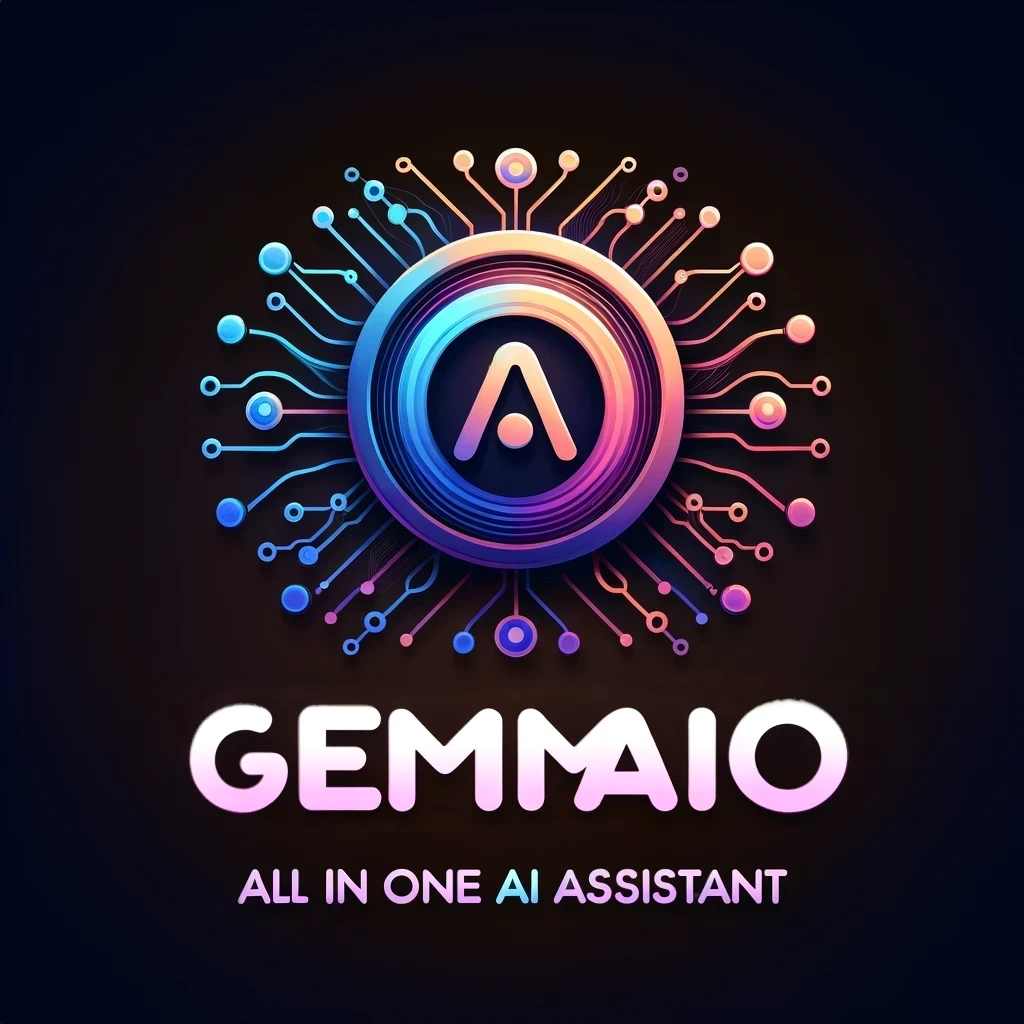

In [1]:
from IPython.display import Image
Image("/kaggle/input/gemmarag-figures/GemmaAIO-main-image.png")

## **What will this chatbot solve?**

This chatbot is designed to simplify the often complex world of data science and coding, making it more accessible. Whether you're deep into data analysis or just dabbling in coding, this tool is here to streamline the process and make your life easier. Here’s what it brings to the table:

- Research Paper Query Engine - Imagine having a librarian at your fingertips who can instantly find the exact research papers you need. This feature cuts down the time you might spend searching through endless academic papers, helping you quickly get the information that's most relevant to your project.

- Graph Paper Relationship Engine - This clever tool helps you see the connections between different research studies. It's like having a map that shows how one discovery leads to another, which can be incredibly useful whether you're trying to understand a new topic or build on existing knowledge.

- Data Science Assistant - Think of this as your personal tutor for statistics and machine learning. It's here to help you navigate the tricky parts of data science.

- AI Code Assistant - this assistant acts like a coding buddy who helps you write, understand, and fix code. It’s perfect for learning the ropes or tackling those tricky problems that can slow you down.

- Combination Module - To top it all off, this feature ensures that all the different tools work together smoothly.

This chatbot is here to demystify data science and coding, turning what might seem like daunting tasks into manageable, even enjoyable ones.

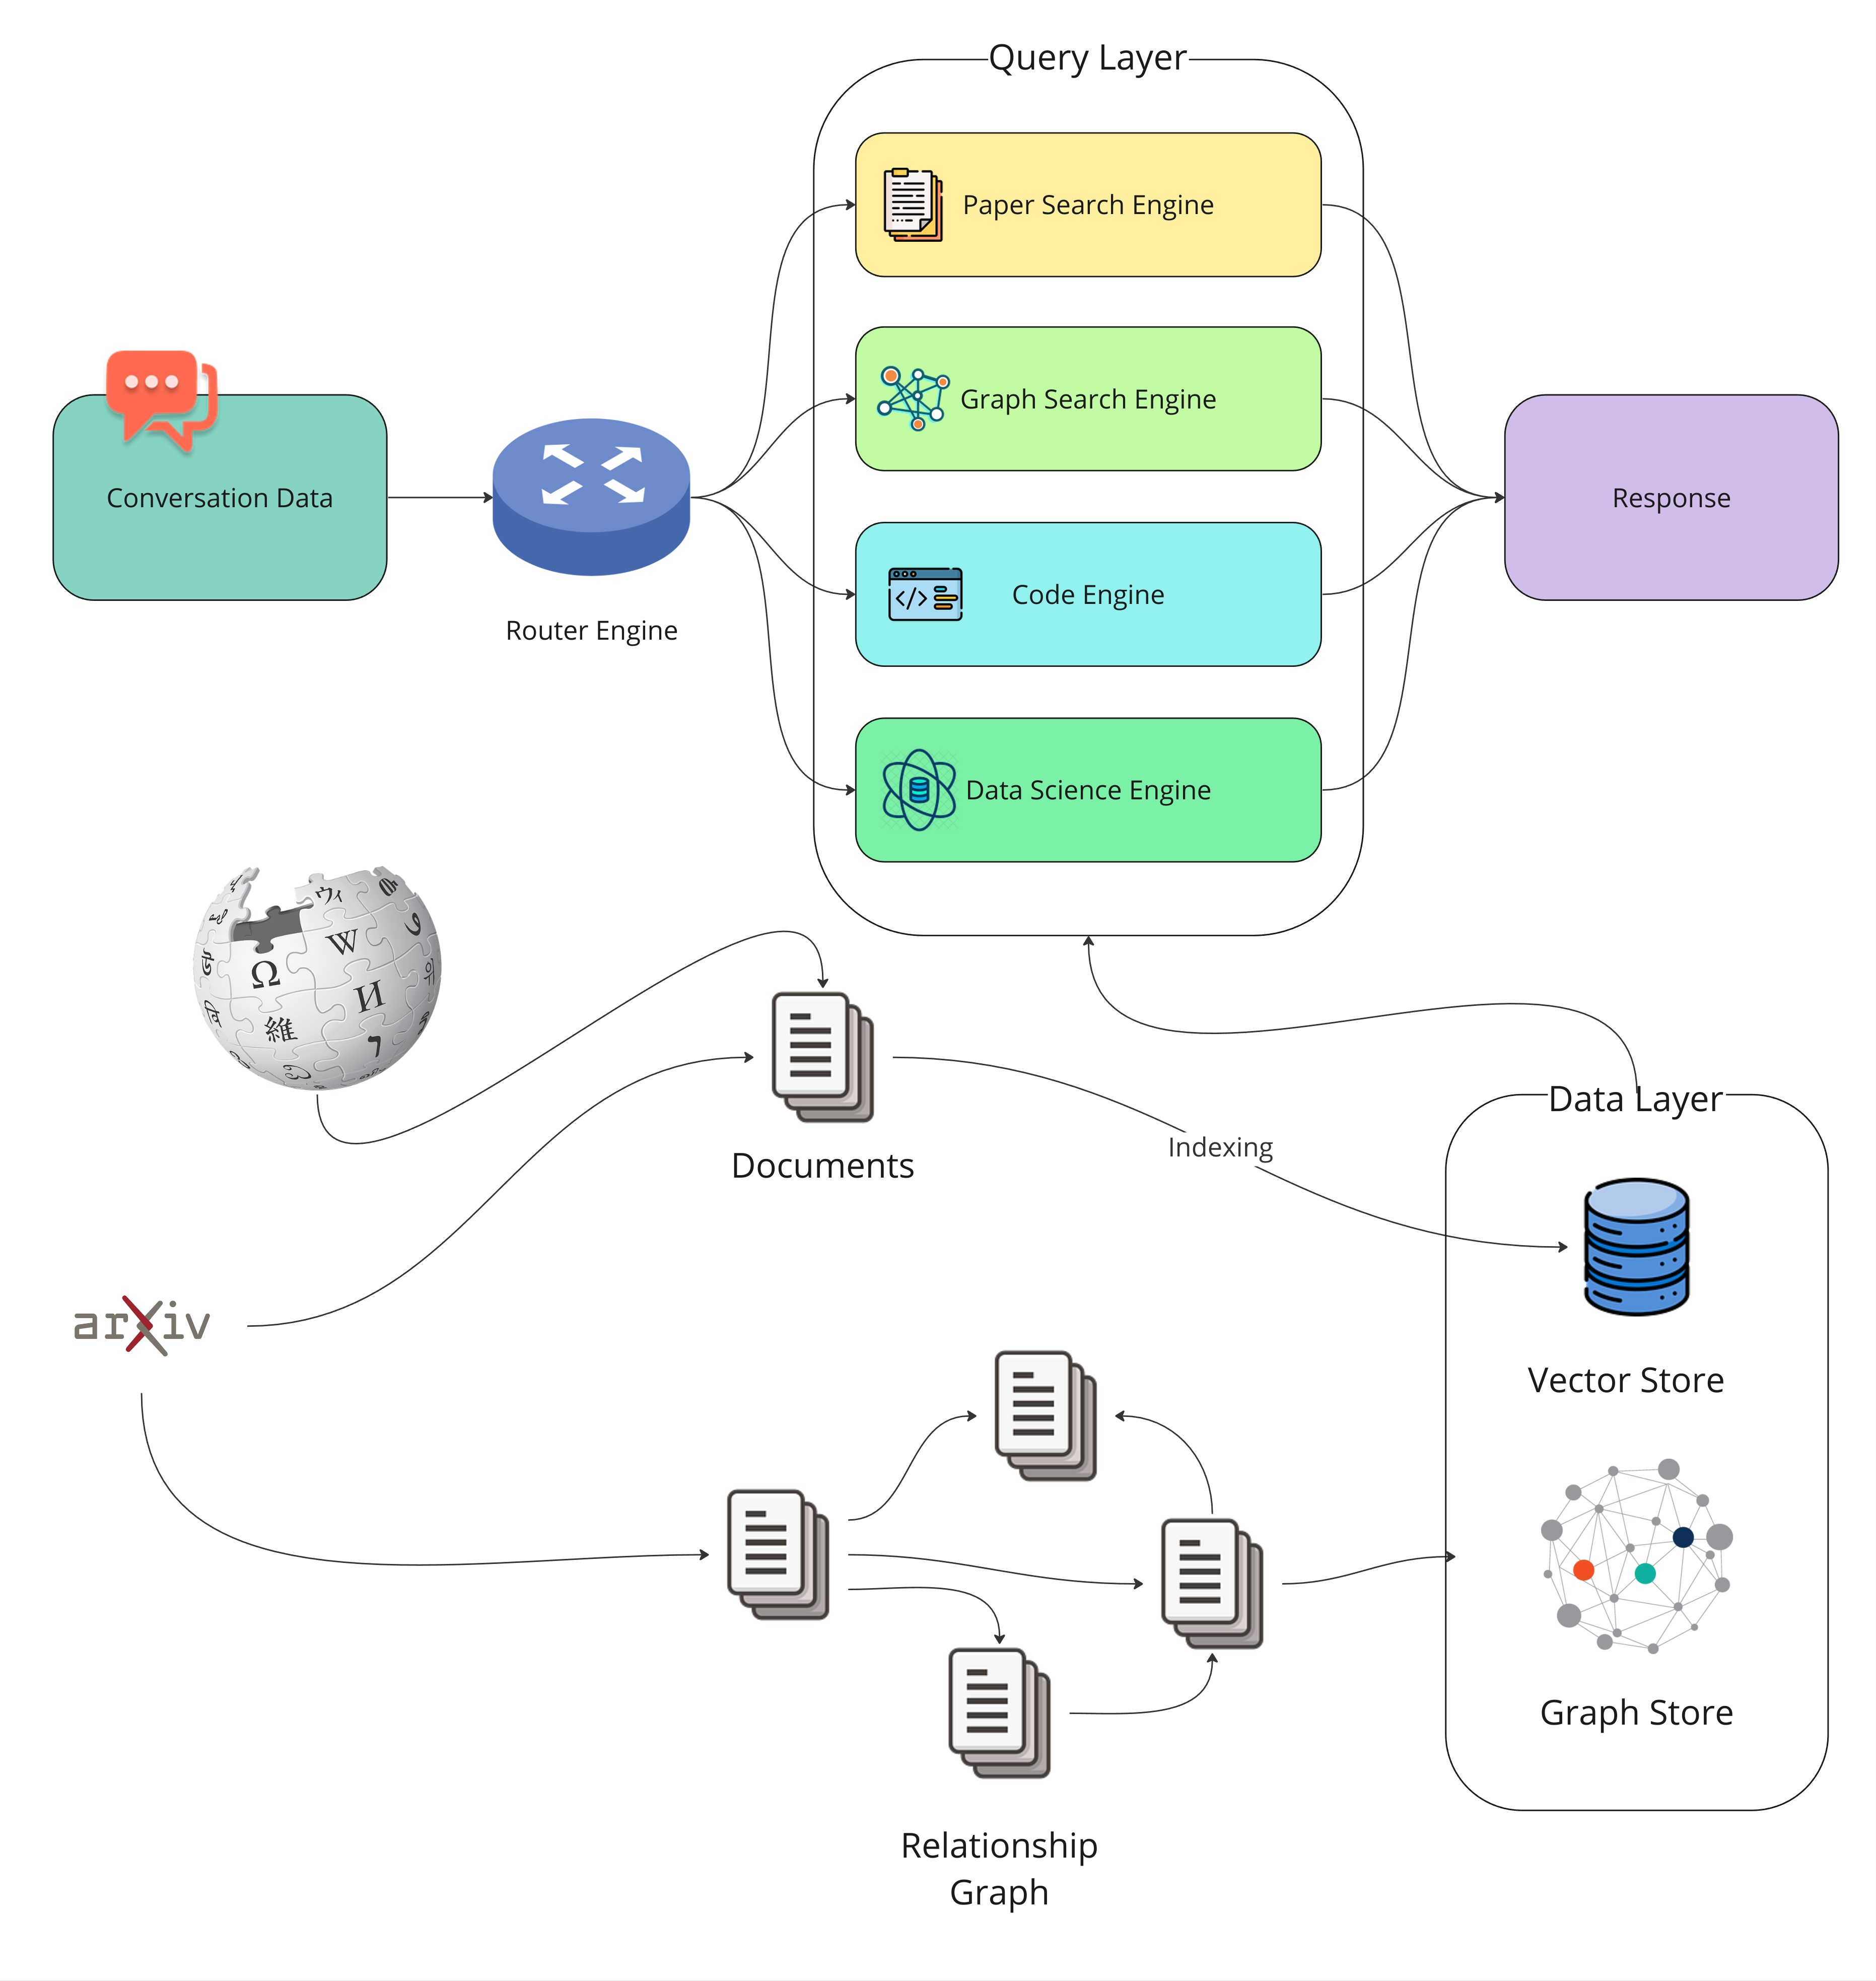

In [2]:
Image("/kaggle/input/gemmarag-figures/RAG-overview.jpg")


Here's the game plan:

- First up, Section 1: We're kicking things off with a research paper query engine. Imagine being able to find any research paper with just a simple chat. Sounds handy, right?

- Moving on to Section 2: We'll spice things up with a graph paper relationship engine. This is all about connecting the dots between different papers and seeing the bigger picture.

- Section 3: We'll add a basic data science assistant to our toolkit. This chatbot will help with all those tricky data questions, from stats to machine learning.

- Section 4 is for the coders: We're building an AI code assistant that's going to be like your coding sidekick, helping you solve problems and understand complex codes.

- And for the grand finale, Section 5: We're bringing it all together with a combination module. This is where we make sure everything works in harmony, giving you a powerhouse tool for any research or coding project.

So, let's roll up our sleeves and jump into this exciting project. An overview of this project is below: 🌟

# **1. Scientific Research Assistant**

In this section, we're focusing on creating the first part of our chatbot: a tool that can search through a huge number of research papers on arXiv. The key to this tool is using embeddings, taken from paper abstracts. Think of these as unique IDs that sum up what each paper is about.

When you ask the chatbot something, it uses these embeddings to look through the abstracts and find papers that really match what you're looking for, not just by keywords, but by the actual ideas and concepts you're interested in. This is more about understanding the meaning of your question and finding papers that really match.

We'll go through everything: picking the right papers from arXiv, getting the abstracts ready, and choosing a way to turn these abstracts into embeddings. Then, we'll set up a smart search that can quickly find the best matches when you ask a question.

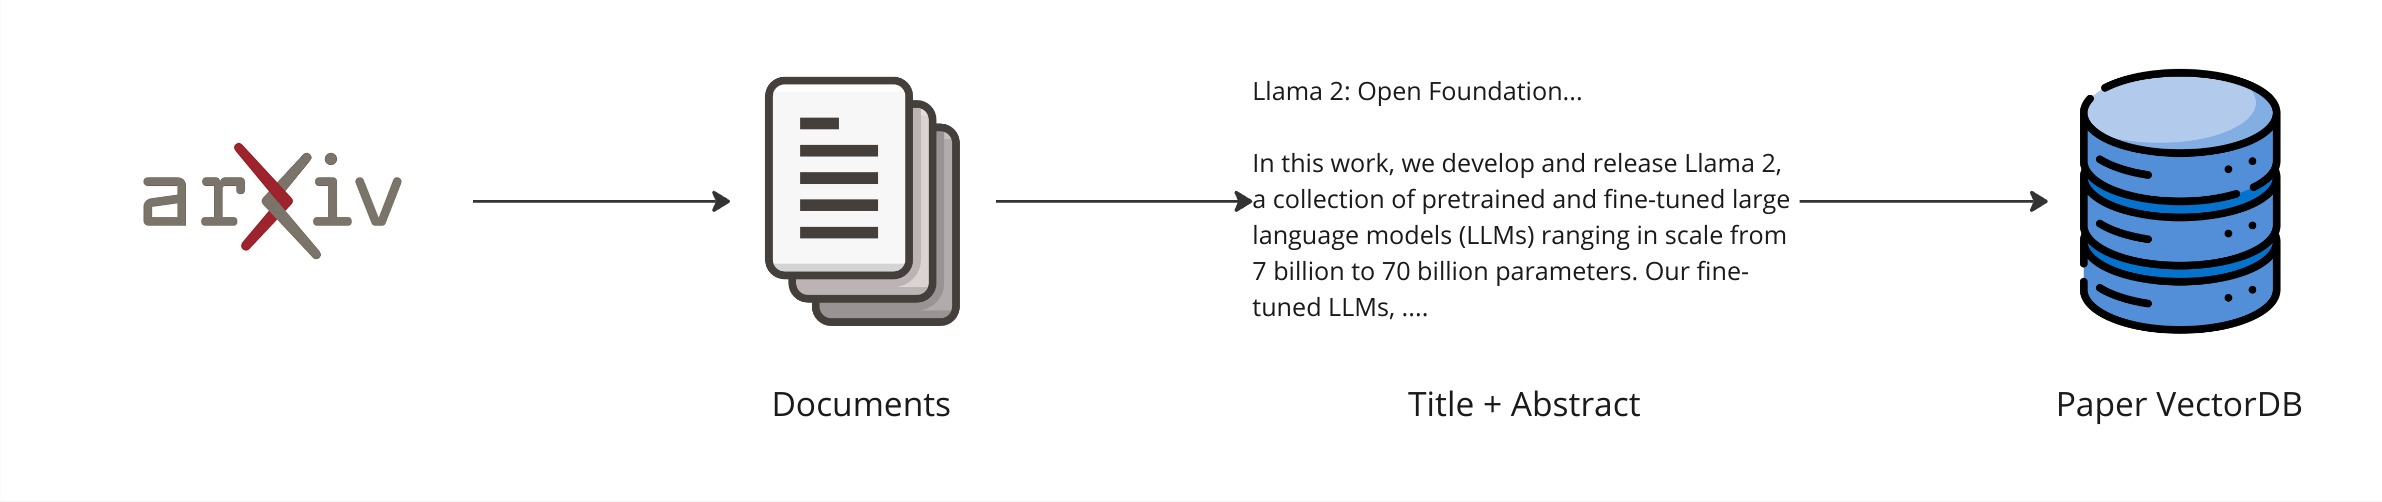

In [3]:
Image("/kaggle/input/gemmarag-figures/Science-Paper-Search.jpg")

## **1.1 Data Preprocessing**

In [4]:
!pip install -q llama-index 
!pip install -q llama-index-embeddings-huggingface 
!pip install -q llama-index-vector-stores-chroma 
!pip install -q chromadb
!pip install -q llama-index-llms-huggingface
!pip install -q llama-index-llms-groq

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
libpysal 4.9.2 requires packaging>=22, but you have packaging 21.3 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
momepy 0.7.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.8.1 which is incompatible.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompatible.
apache-beam 2.46.0 requires numpy<1.25.0,>=1.14.3, but you have numpy 1.26.4 which is incompat

In [5]:
# https://www.kaggle.com/code/matthewmaddock/nlp-arxiv-dataset-transformers-and-umap

# This takes about 1 minute.
import json
import pandas as pd

cols = ['id', 'title', 'abstract', 'categories']
data = []
file_name = '../input/arxiv/arxiv-metadata-oai-snapshot.json'


with open(file_name, encoding='latin-1') as f:
    for line in f:
        doc = json.loads(line)
        lst = [doc['id'], doc['title'], doc['abstract'], doc['categories']]
        data.append(lst)

df_data = pd.DataFrame(data=data, columns=cols)

print(df_data.shape)

df_data.head()

(2459562, 4)


id                                              title  \
0  0704.0001  Calculation of prompt diphoton production cros...   
1  0704.0002           Sparsity-certifying Graph Decompositions   
2  0704.0003  The evolution of the Earth-Moon system based o...   
3  0704.0004  A determinant of Stirling cycle numbers counts...   
4  0704.0005  From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...   

                                            abstract       categories  
0    A fully differential calculation in perturba...           hep-ph  
1    We describe a new algorithm, the $(k,\ell)$-...    math.CO cs.CG  
2    The evolution of Earth-Moon system is descri...   physics.gen-ph  
3    We show that a determinant of Stirling cycle...          math.CO  
4    In this paper we show how to compute the $\L...  math.CA math.FA

There are a total of almost 2,5M papers on arxiv, that's too much! However, not all of them are about AI, so let's narrow down to the topics we're interested in.

In [6]:
import pandas as pd

topics = ['cs.AI', 'cs.CV', 'cs.IR', 'cs.LG', 'cs.CL']

# Create a regular expression pattern that matches any of the topics
# The pattern will look like 'cs.AI|cs.CV|cs.IR|cs.LG|cs.CL'
pattern = '|'.join(topics)

# Filter the DataFrame to include rows where the 'categories' column contains any of the topics
# The na=False parameter makes sure that NaN values are treated as False
df_filtered = df_data[df_data['categories'].str.contains(pattern, na=False)]

# Display the filtered DataFrame
df_filtered

id                                              title  \
46              0704.0047  Intelligent location of simultaneously active ...   
49              0704.0050  Intelligent location of simultaneously active ...   
303             0704.0304                  The World as Evolving Information   
670             0704.0671              Learning from compressed observations   
953             0704.0954  Sensor Networks with Random Links: Topology De...   
...                   ...                                                ...   
2447948  quant-ph/0411140     Improved Bounds on Quantum Learning Algorithms   
2449818  quant-ph/0507231  Algebras of Measurements: the logical structur...   
2452665  quant-ph/0607111  `Plausibilities of plausibilities': an approac...   
2454377  quant-ph/0702072                    Markovian Entanglement Networks   
2456457  quant-ph/9802028       Analogue Quantum Computers for Data Analysis   

                                                  abstract  \
46         The intelligent acoustic emission locator is...   
49         Part I describes an intelligent acoustic emi...   
303        This paper discusses the benefits of describ...   
670        The problem of statistical learning is to co...   
953        In a sensor network, in practice, the commun...   
...                                                    ...   
2447948    In this article we give several new results ...   
2449818    In Quantum Physics, a measurement is represe...   
2452665    Probability-like parameters appearing in som...   
2454377    Graphical models of probabilistic dependenci...   
2456457    Analogue computers use continuous properties...   

                           categories  
46                        cs.NE cs.AI  
49                        cs.NE cs.AI  
303      cs.IT cs.AI math.IT q-bio.PE  
670               cs.IT cs.LG math.IT  
953               cs.IT cs.LG math.IT  
...                               ...  
2447948                quant-ph cs.LG  
2449818                quant-ph cs.AI  
2452665                quant-ph cs.AI  
2454377                quant-ph cs.AI  
2456457                quant-ph cs.CV  

[338304 rows x 4 columns]

Great! Now we down to about 330K papers. Now, let's clean the text.

In [7]:
df_filtered.iloc[110]

id                                                    0707.0705
title         Optimal Solutions for Sparse Principal Compone...
abstract        Given a sample covariance matrix, we examine...
categories                                          cs.AI cs.LG
Name: 13875, dtype: object

In [8]:
def clean_text(x):
    
    # Replace newline characters with a space
    new_text = " ".join([c.strip() for c in x.replace("\n", "").split()])
    # Remove leading and trailing spaces
    new_text = new_text.strip()
    
    return new_text

df_data['title'] = df_data['title'].apply(clean_text)
df_data['abstract'] = df_data['abstract'].apply(clean_text)

df_data['prepared_text'] = df_data['title'] + '\n ' + df_data['abstract']
df_data.head()

id                                              title  \
0  0704.0001  Calculation of prompt diphoton production cros...   
1  0704.0002           Sparsity-certifying Graph Decompositions   
2  0704.0003  The evolution of the Earth-Moon system based o...   
3  0704.0004  A determinant of Stirling cycle numbers counts...   
4  0704.0005  From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...   

                                            abstract       categories  \
0  A fully differential calculation in perturbati...           hep-ph   
1  We describe a new algorithm, the $(k,\ell)$-pe...    math.CO cs.CG   
2  The evolution of Earth-Moon system is describe...   physics.gen-ph   
3  We show that a determinant of Stirling cycle n...          math.CO   
4  In this paper we show how to compute the $\Lam...  math.CA math.FA   

                                       prepared_text  
0  Calculation of prompt diphoton production cros...  
1  Sparsity-certifying Graph Decompositions\n We ...  
2  The evolution of the Earth-Moon system based o...  
3  A determinant of Stirling cycle numbers counts...  
4  From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...

In [9]:
# from llama_index.core import Document

# arxiv_documents = [Document(text=prepared_text, doc_id=id) for prepared_text,id in list(zip(df_data['prepared_text'], df_data['id']))]

## **1.2 Creating Index**

The `VectorStoreIndex` is by far the most frequently used type of Index in llamaindex. This class takes your Documents and splits them up into Nodes. Then, it creates `vector_embeddings` of the text of every node. But what is `vector_embedding`?

Vector embeddings are like turning the essence of your words into a mathematical sketch. Imagine every idea or concept in your text getting its unique numerical fingerprint. This is handy because even if two snippets of text use different words, if they're sharing the same idea, their numerical sketches—or embeddings—will be close neighbors in the numerical space. This magic is done using tools known as embedding models.

Choosing the right embedding model is crucial. It's like picking the right artist to paint your portrait; you want the one who captures you best. A great place to start is the MTEB leaderboard, where the crème de la crème of embedding models are ranked. As we have quite a large dataset, the model size matters, we don't want to wait all day for the model to extract all the vector embeddings. When I last checked, the `BAAI/bge-small-en-v1.5` model was leading the pack, especially considering its size. It could be a solid choice if you're diving into the world of text embeddings.


Note: *The embedding process may take a considerable amount of time. To save time, I have precomputed it. If you wish to execute the process from the beginning, uncomment the following code.*

In [10]:
from llama_index.core import VectorStoreIndex
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core import Settings
import chromadb
import torch
from llama_index.vector_stores.chroma import ChromaVectorStore
from llama_index.core import StorageContext

Settings.llm = None
# Create embed model
device_type = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5", cache_folder="../models", device=device_type)

LLM is explicitly disabled. Using MockLLM.


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/94.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Great! Now we have to find somewhere to store all of the embeddings extracted by the model, and that's why we need a `vector store`. There are many to choose from, in this tutorial, I will choose the `chroma` vector store

In [11]:
# chroma_client = chromadb.PersistentClient(path="../DB/arxiv")
# chroma_collection = chroma_client.get_or_create_collection("gemma_assistant_arxiv_papers")


# # Create vector store
# vector_store = ChromaVectorStore(chroma_collection=chroma_collection)
# storage_context = StorageContext.from_defaults(vector_store=vector_store)

This part takes quite a lot of time! So I precomputed the embedding and store them into chroma db

In [12]:
# index = VectorStoreIndex.from_documents(
#     arxiv_documents, storage_context=storage_context, embed_model=embed_model, show_progress=True
# )

## **1.3 Loading from arxiv vector store**

Now, let's load the precomputed embeddings!

In [13]:
!cp -r /kaggle/input/gemma-assistant-db .

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [14]:
from llama_index.core import VectorStoreIndex, Settings
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
import chromadb
from llama_index.vector_stores.chroma import ChromaVectorStore
from llama_index.core import StorageContext
import torch


Settings.llm = None # Set this to none to make the index only do retrieval
device_type = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5", cache_folder="../models", device=device_type) # must be the same as the previous stage

chroma_client = chromadb.PersistentClient(path="./gemma-assistant-db/arxiv")
chroma_collection = chroma_client.get_or_create_collection("gemma_assistant_arxiv_papers")
vector_store = ChromaVectorStore(chroma_collection=chroma_collection)
# load the vectorstore
storage_context = StorageContext.from_defaults(vector_store=vector_store)
paper_index = VectorStoreIndex.from_vector_store(vector_store, storage_context=storage_context, embed_model=embed_model)

LLM is explicitly disabled. Using MockLLM.


In [15]:
paper_query_engine = paper_index.as_query_engine(
    similarity_top_k=5,
)

In [16]:
print(paper_query_engine.query("What are some papers about image generation?"))

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Context information is below.
---------------------
deep image synthesis from intuitive user input: a review and perspectives
 In many applications of computer graphics, art and design, it is desirablefor a user to provide intuitive non-image input, such as text, sketch, stroke,graph or layout, and have a computer system automatically generatephoto-realistic images that adhere to the input content. While classic worksthat allow such automatic image content generation have followed a framework ofimage retrieval and composition, recent advances in deep generative models suchas generative adversarial networks (GANs), variational autoencoders (VAEs), andflow-based methods have enabled more powerful and versatile image generationtasks. This paper reviews recent works for image synthesis given intuitive userinput, covering advances in input versatility, image generation methodology,benchmark datasets, and evaluation metrics. This motivates new perspectives oninput representation and interact

## **1.4 Gemma Inference at super speed**

In this notebook, I will demonstrate the use of the Groq API service for Gemma inference. Here's why I've chosen Groq for this task:

- Groq offers incredibly fast inference speeds, approximately 700-800 tokens per second. This high performance allows for the execution of complex RAG pipelines without concerns about speed limitations.

- Enhanced performance: On platforms like Kaggle, we are restricted to using only the quantized Gemma model, which yields poorer and less consistent results. Utilizing an API service like Groq simplifies the process and enhances the outcomes.

- Generous free tier: Groq provides a substantial number of requests on its free tier, making it an accessible option for extensive testing and development.

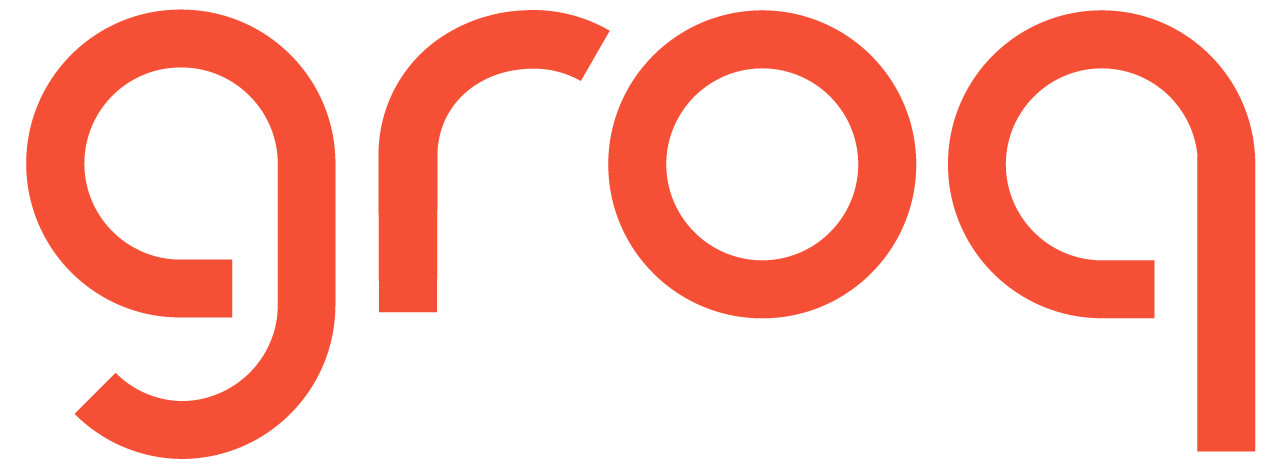

In [17]:
Image("/kaggle/input/gemmarag-figures/groq-logo.png")

The first step is to create a Groq account, after which you can generate a new API token like the following image

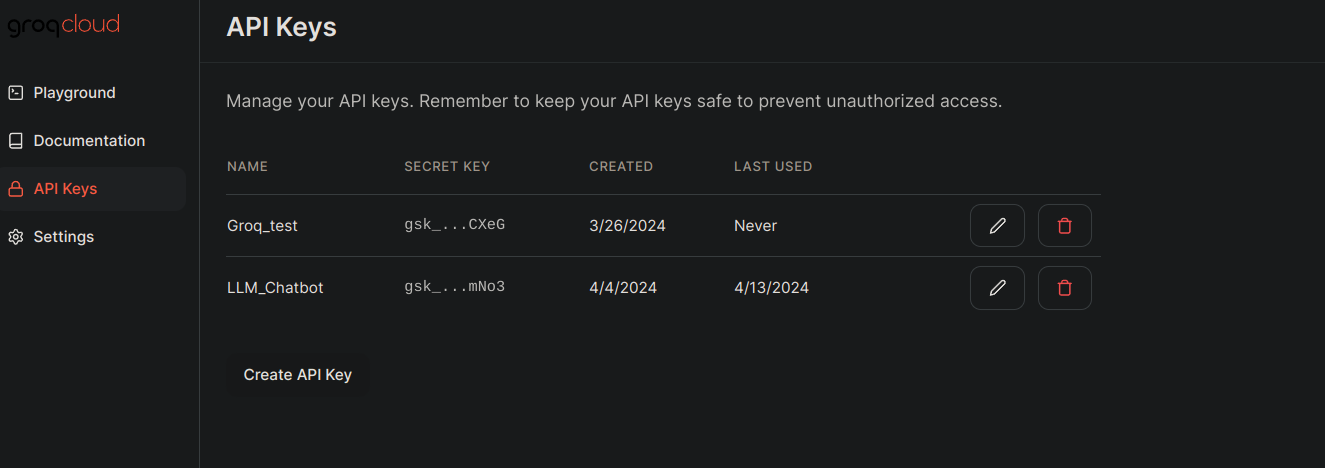

In [18]:
Image("/kaggle/input/gemmarag-figures/create-groq-key.png")

Then you could put your newly generate token to the kaggle secrets section. Go too Add-ons -> Secrets -> Add a new secret key (with a name you like)

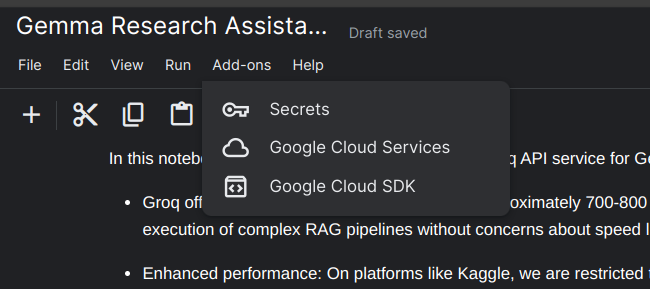

In [19]:
Image("/kaggle/input/gemmarag-figures/secret-kaggle.png")

Now, we can use this token to inference LLM at super speed with Groq! Groq gives about 14400 request per day, and 30 request per minute for gemma model, which is a lot for personal use.

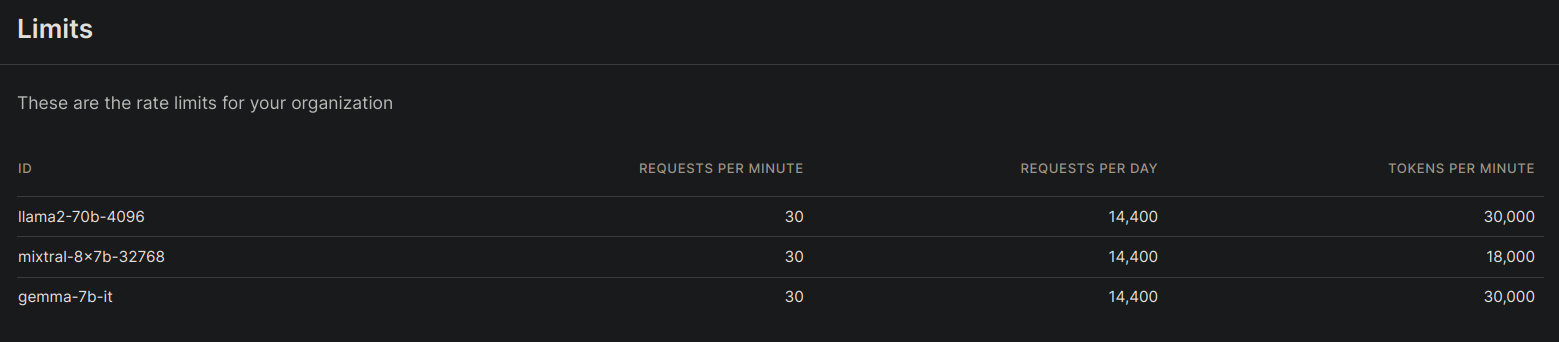

In [20]:
Image("/kaggle/input/gemmarag-figures/Groq-Rate-Limits.png")

In [21]:
from llama_index.llms.groq import Groq
from kaggle_secrets import UserSecretsClient
from llama_index.core import Settings

secret_label = 'groq'
groq_token = UserSecretsClient().get_secret(secret_label)


llm = Groq("gemma-7b-it", api_key=groq_token)
Settings.llm = llm

In [22]:
from IPython.display import Markdown

Markdown(llm.complete("What is linear regression?").text)

**Linear regression** is a statistical method used to model the relationship between a dependent variable and one or more independent variables. It is a simple and widely used technique for **predictive modeling** and **understanding the influence** of independent variables on the dependent variable.

**How it works:**

- Linear regression finds a straight line that best fits the data points, minimizing the sum of the squared errors between the predicted values and the actual values.
- The equation of a straight line is: $$y = a + bx$$ where:
    - **y** is the dependent variable
    - **a** is the intercept (the value of y when x is 0)
    - **b** is the slope (the change in y for a one-unit change in x)

**Assumptions of linear regression:**

- Linearity: The relationship between the dependent and independent variables is straight.
- Homoscedasticity: The variance of the residuals (the difference between the predicted and actual values) is constant.
- Normality: The residuals are normally distributed.
- Independence: The observations are independent of each other.

**Applications of linear regression:**

- **Predictive modeling:** Forecasting future values based on historical data.
- **Trend analysis:** Identifying trends and patterns in data.
- **Relationship analysis:** Determining the influence of independent variables on the dependent variable.
- **Quality control:** Identifying factors that affect product or process quality.

**Key concepts in linear regression:**

- **Correlation:** The strength and direction of the relationship between two variables.
- **Coefficient of determination (R²):** The proportion of the variance in the dependent variable that is explained by the independent variables.
- **Standard error of the estimate:** An estimate of the uncertainty in the coefficient estimates.
- **Significance:** The probability of obtaining the observed coefficient values if the null hypothesis (no relationship between the variables) is true.

In [23]:
paper_query_engine = paper_index.as_query_engine(
    similarity_top_k=10,
    llm=llm
)

In [24]:
Markdown(paper_query_engine.query("What are some papers about using diffusion for generating video data?").response)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

The provided text contains several papers related to using diffusion for generating video data:

**Papers discussing video diffusion models:**

- **VideoFusion:** Decomposed diffusion process for high-quality video generation.
- **Diffusion Probabilistic Modeling for Video Generation:** Autoregressive diffusion model for generating video.
- **Frame by Familiar Frame:** Investigating sample replication in video diffusion models.
- **GD-VDM:** Diffusion model for generating videos by first generating depth videos.
- **Stable Video Diffusion:** Latent video diffusion model for high-resolution video generation.
- **VIDM:** Video implicit diffusion models for generating high-quality videos.

**Papers reviewing diffusion models for video generation:**

- **Video Diffusion Models:** Comprehensive survey of diffusion models, covering efficient sampling, likelihood estimation, and handling data with special structures.

# **2. Graph-based paper relationship search**

In this section, we dive into constructing a knowledge graph about the relationships of papers. This graph could be used for interactive visualization, searching relationships between papers (e.g. How is paper A related to paper B), or search for a specific relationship in a paper (e.g. What are works that paper A based on?). The steps of constructing this knowledge graph are:


- Step 1: arXiv Data Extraction: The process starts with academic papers from the arXiv database, which undergo OCR (Optical Character Recognition) and PDF parsing, which organizes the content into structured data such as the title, abstract, sections, and references of the papers. 

- Step 2: Text Splitter: The text in each section is then processed by a Text Splitter, which split the paper section into smaller chunks, which could be easier for LLMs to process.  

- Step 3 GPT-3.5 Processing: Gemma couldn't generate the knowledge graph out-of-the-box. So we need knowledge distillation from a bigger model, which I choose GPT-3.5. The structured data is passed to GPT-3.5 to extract citation relationships, such as "Data Source", "Extension", or "Theoretical Foundation", etc. Each relationship is paired with a dense explanation. I extracted a total of ~300 papers, which cost around 4$.

- Step 4 Training Gemma - 7B: The distilled knowledge data are then used to train Gemma-7b. Then I use this model to generate citation relationships for as many papers as I can. In total, I extracted 7k papers, with around 150K triplets! Crazy!!

- Step 5 Graph Store: Finally, a Graph Store is created containing 7K papers and 586K triplets. This could then be used for searching relationships or visualization.


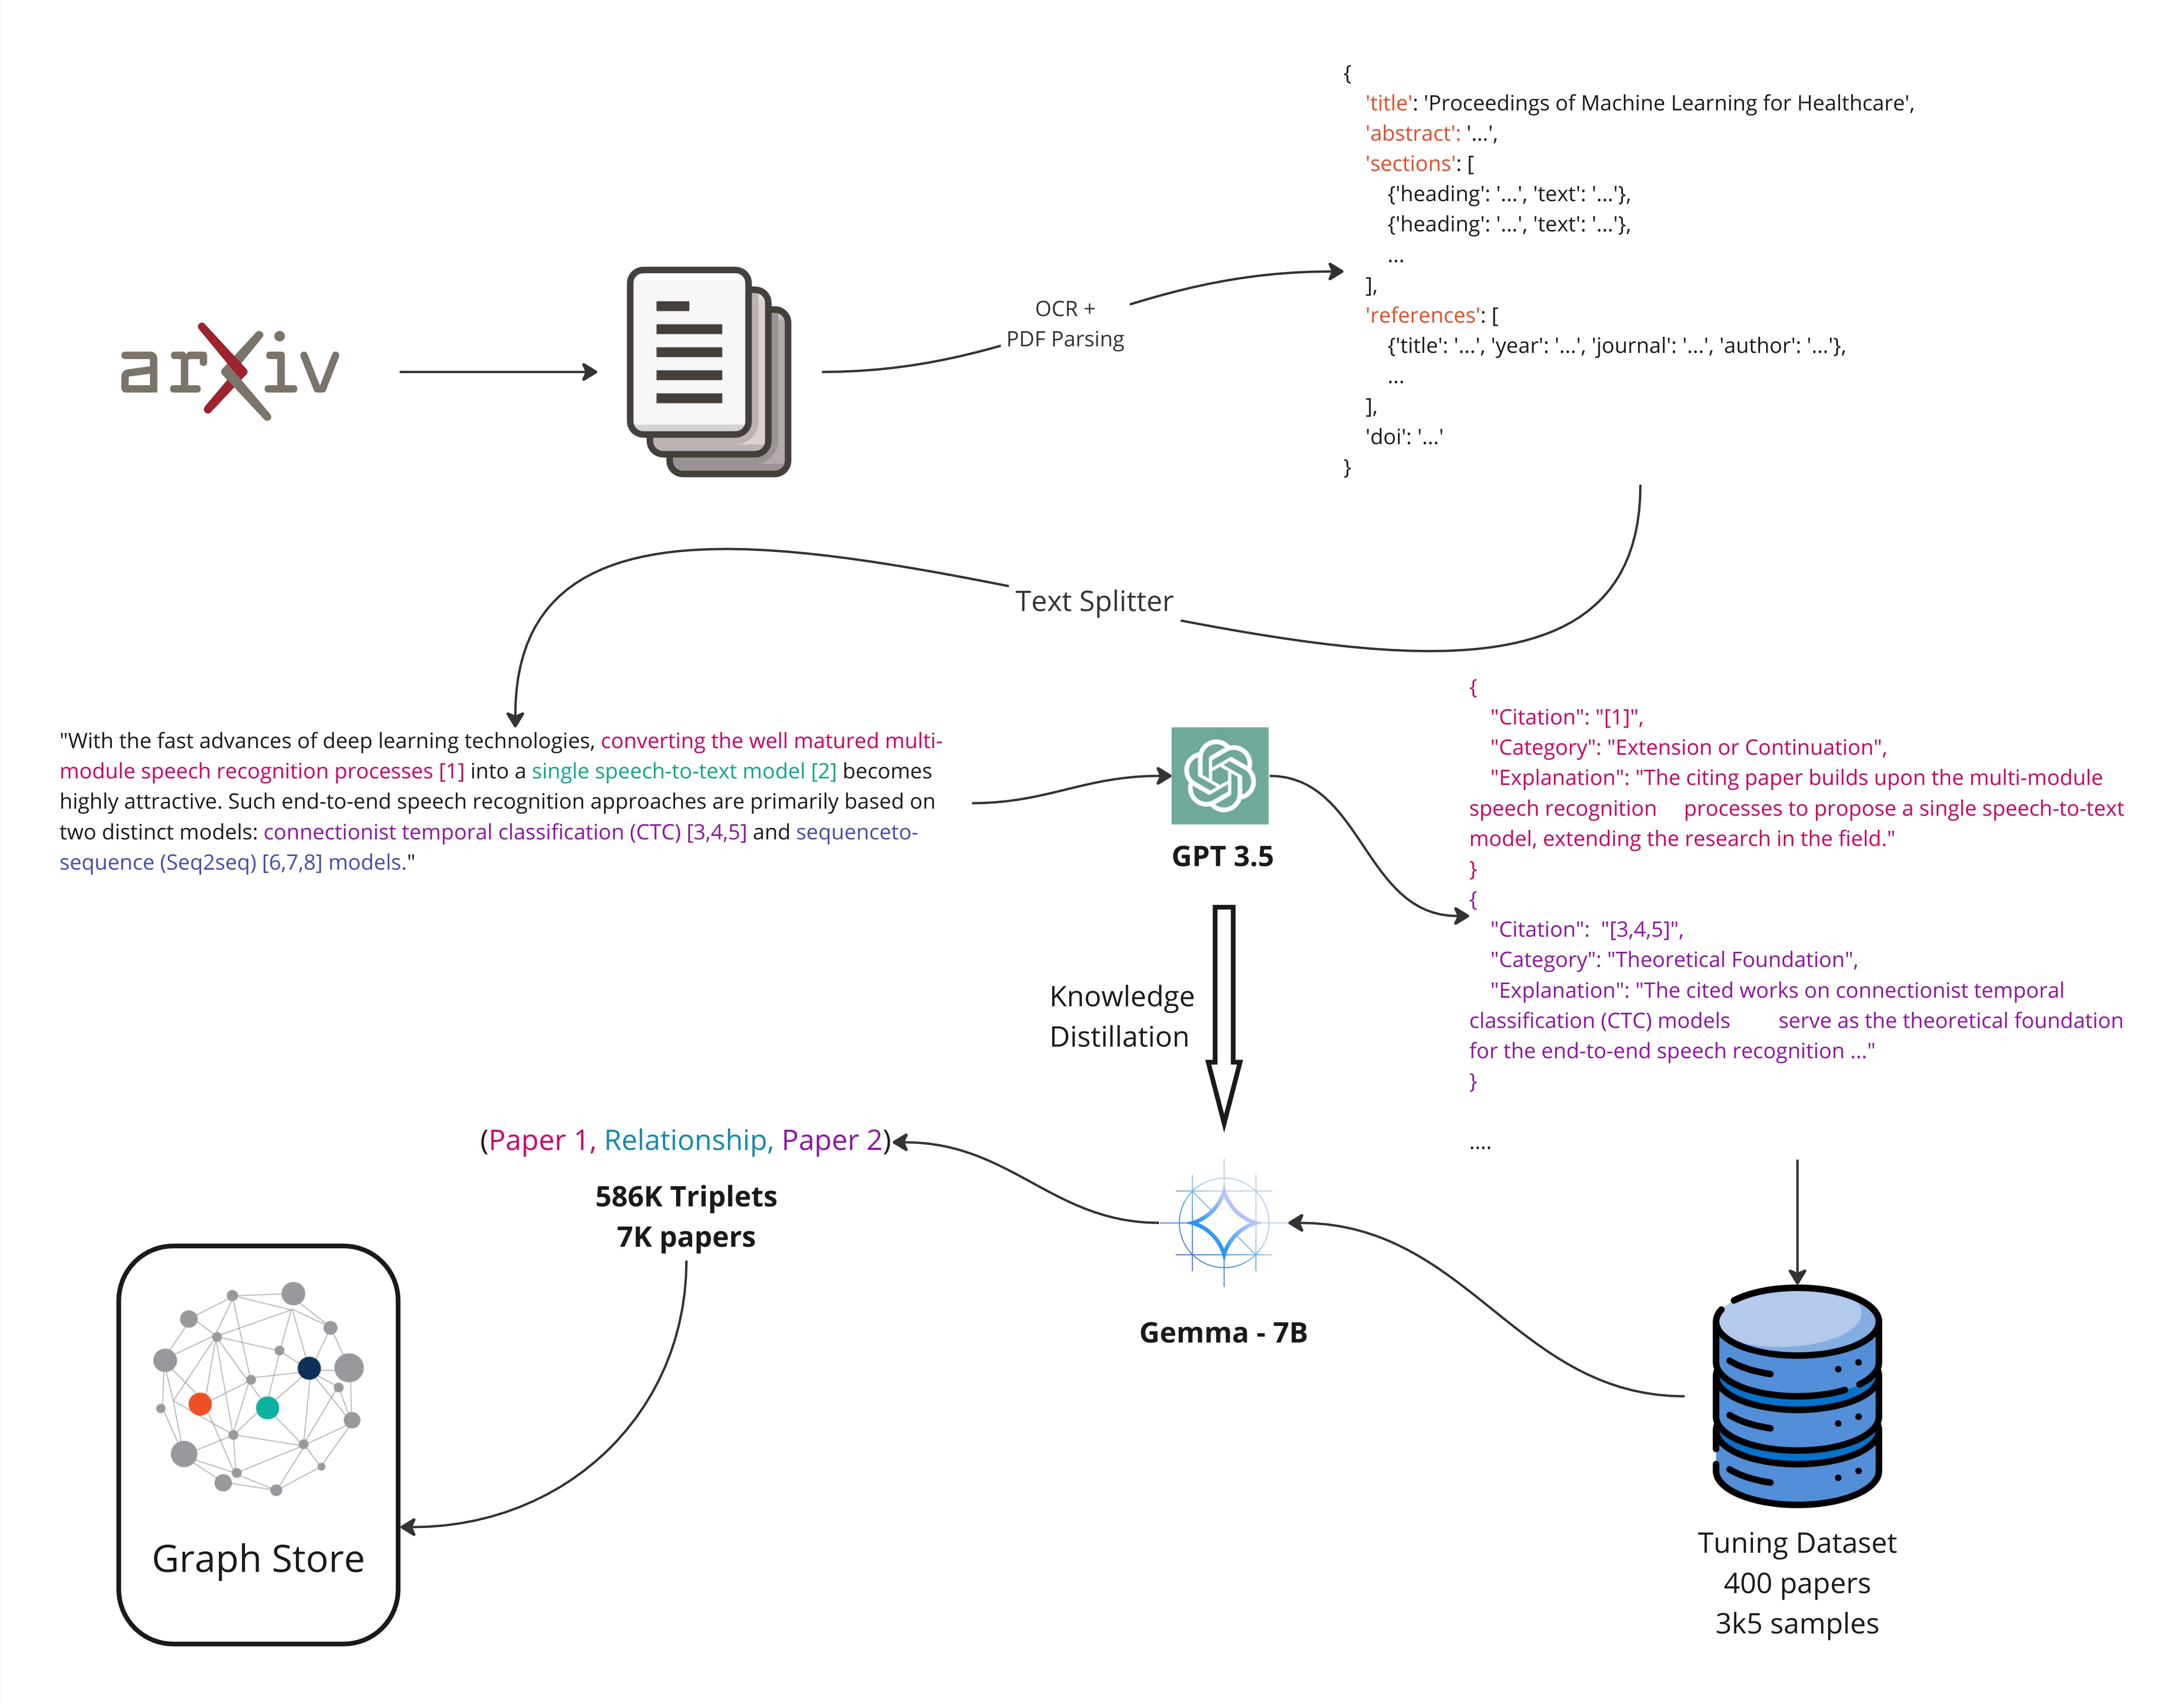

In [25]:
Image("/kaggle/input/gemmarag-figures/Graph-Paper-Search.jpg")

## **2.0 Extracting Data + Knowledge distillation**

**Knowledge distillation** involves training a smaller, less complex model (termed the "student") to mimic the behavior of a larger, more intricate model (referred to as the "teacher"). The objective is to impart the teacher model's knowledge to the student model so that the student can perform comparably but more efficiently and with reduced computational demands. To achieve this, the student model learns not only from the direct outputs, such as class labels in classification tasks, but also from the softer, indirect outputs like the probability distributions or the feature representations that the teacher model produces. This technique is especially valuable for deploying advanced AI models on devices with constrained computational resources, such as smartphones or embedded systems.

In this project, I initially utilized OCR and PDF reader tools to extract textual information from PDF files. The extracted text was then segmented and input into GPT-3.5 to create a dataset for distilling knowledge into Gemma-7B. This dataset is accessible here: [citation data](https://www.kaggle.com/datasets/bachngoh/citation-generation-train)

Here are some training samples:
```json

{
            "Input": "Additionally, generalizing over objects, actions and events allow users to make predictions of upcoming Effects even for unseen events (Radinsky, Davidovich, and Markovitch 2012). Therefore, in our work, we condense our graphs by grouping nodes that refer to the same topic together using previous topic modelling solutions (Sia, Dalmia, and Mielke 2020;Zhang et al. 2022)."
            "Output":[
    {
        "Citation": "(Radinsky, Davidovich, and Markovitch 2012)"
        "Category": "Theoretical Foundation"
        "Explanation": "The cited work establishes the importance of generalizing over objects, actions, and events to make predictions, which forms the theoretical basis for the approach taken in the citing paper."
    },
    {
        "Citation":"(Sia, Dalmia, and Mielke 2020; Zhang et al. 2022)"
        "Category":"Methodological Basis"
        "Explanation":"The cited works introduce the method of condensing graphs by grouping nodes based on topic modeling solutions, which is adopted by the citing paper to structure its analysis."}]
}

```

```json

{
        "Input":"The proposed GIFT was implemented into three PLMs. • BERT (Devlin et al., 2019) was pre-trained to learn universal language representations on a large amount of general corpora with the self-supervised tasks of MLM and NSP. • SA-BERT (Gu et al., 2020) added speaker embeddings and further pre-trained BERT on a domain-specific corpus to incorporate domain knowledge. We re-implemented SA-BERT on the same pre-training corpus used in this paper to ensure fair comparison. • MPC-BERT (Gu et al., 2021) was pre-trained with two major types of self-supervised tasks for modeling interlocutor structures and utterance semantics in a unified framework. (2016). For models with GIFT, numbers marked with ‡ denoted larger performance improvement or less performance drop compared with the corresponding models without GIFT."
        "Output":[
    {
        "Citation":"(Devlin et al., 2019)"
        "Category":"Methodological Basis"
        "Explanation":"The cited work, BERT, serves as the basis for pre-training language representations using self-supervised tasks of MLM and NSP, which is adopted by the citing paper for implementing the proposed GIFT into PLMs."
    }
    {
        "Citation":"(Gu et al., 2020)"
        "Category":"Extension or Continuation"
        "Explanation":"SA-BERT, as cited, extends the pre-training of BERT by incorporating speaker embeddings and domain-specific knowledge, which is further explored and re-implemented in the citing paper for a fair comparison."
    }
    {
        "Citation":"(Gu et al., 2021)"
        "Category":"Extension or Continuation"
        "Explanation":"MPC-BERT, referenced in the text, extends the pre-training of BERT by incorporating self-supervised tasks for modeling interlocutor structures and utterance semantics, which is further explored in the citing paper for enhancing language representations."}]
}

```

Subsequently, I employed the unsloth framework to train the model. The training process is outlined in this [notebook](https://www.kaggle.com/code/bachngoh/training-gemma-7b-the-right-way). The models produced include:

- The Gemma-7B 16bit full model version [gemma-7b-16bit](https://huggingface.co/BachNgoH/Gemma_7b_Citation_16bit)

- The Gemma-7B lora version [gemma-7b-lora](https://huggingface.co/BachNgoH/Gemma_7b_Citation_lora)

- The Gemma-7B version in unsloth format [gemma-7b-unsloth](https://huggingface.co/BachNgoH/Gemma_7B_Citation)


Finally, I put the trained Gemma models to work, using them to extract detailed citation information from another 7,000 papers. This effort was designed to gather extensive relationship data, enhancing our understanding of the connections within the academic literature. You can found the dataset here [parsed arxiv papers dataset](https://huggingface.co/datasets/BachNgoH/ParsedArxivPapers)

## **2.1 Download pre-extracted citation data**

In [26]:
from datasets import load_dataset

parsed_article = load_dataset("BachNgoH/ParsedArxivPapers")['train']

Generating train split:   0%|          | 0/19454 [00:00<?, ? examples/s]

In [27]:
import datasets
datasets.__version__

'2.18.0'

In [28]:
parsed_article = parsed_article.to_list()

In [29]:
import json

for article in parsed_article:
    if article['citation_data'] != None:
        article['citation_data'] = json.loads(article['citation_data'])

In [30]:
parsed_article[312]['citation_data'][:5]

[{'Category': 'Methodological Basis',
  'Citation': '[19]',
  'Explanation': 'The cited work on semi-supervised learning provides a foundational basis for the discussion of graph-based methods in the citing paper, as the paper builds upon the idea of utilizing unlabeled data in a graph structure for machine learning tasks.'},
 {'Category': 'Methodological Basis',
  'Citation': '[75]',
  'Explanation': 'The cited work introduces the concept of persistent spectral graphs, which the citing paper adopts to extend the standard combinatorial Laplacian to the filtration setting and obtain topological invariants in the data.'},
 {'Category': 'Extension or Continuation',
  'Citation': '[57]',
  'Explanation': 'The citing paper adapts the classical MBO scheme from the cited work to a graph framework for data classification, extending the original method to a new context.'},
 {'Category': 'Methodological Basis',
  'Citation': '[83]',
  'Explanation': 'The cited work introduces the concept of dire

Let's see the number of annotated papers for now!

In [31]:
annotated_article = [x for x in parsed_article if x['citation_data'] is not None]

In [32]:
print("Annotated Papers: ", len(annotated_article))

Annotated Papers:  7243


## **2.2 Parsing generated data**

From my observation, there are 2 main citation styles in AI papers, Author-year style and Numeric style:

Example of Author-year style:
- (Bassignana and Plank, 2022a) 
- (Liu et al., 2021)
- (Köksal and Özgür, 2020)

Example of Numeric style:
- [1], [2], [3]
- [2, 56, 67]
- [7 - 9]

Therefore, we need different strategy to handle each style of citation

### **2.2.1 Handle Author-Year citation style**

Handling this citation style can be quite frustrating. Initially, we must separate combined citations like (Liu et al., 2021; Littell et al., 201) into individual entries. Then, we need to identify the first author and publication year. Subsequently, we have to locate the corresponding reference within our reference list based on the author's name and publication year.

In [33]:
# Parse annotated articles
import re

# Function to normalize author names for comparison
def normalize_author_name(name):
    # Convert to lowercase and remove middle initials
    name = name.lower()
    name = re.sub(r"\s+[a-z]\.", "", name)  # Remove middle initials
    return name


citation_names = [c['Citation'] for c in annotated_article[0]['citation_data']]
citation_names

['(Cohn et al., 1996)',
 '(Settles, 2009)',
 '(Dasgupta, 2011)',
 '(Gururangan et al., 2020)',
 '(Houlsby et al., 2019)',
 '(Pfeiffer et al., 2023)',
 '(He et al., 2021;Li and Liang, 2021;Karimi Mahabadi et al., 2021)',
 '(Toneva et al., 2019)',
 '(Ein-Dor et al., 2020)',
 '(Margatina et al., 2021)',
 '(Shelmanov et al., 2021)',
 '(Karamcheti et al., 2021)',
 '(Schröder et al., 2022)',
 '(Mosbach et al., 2021)',
 '(Zhang et al., 2021)',
 '(Dodge et al., 2020)',
 '(Grießhaber et al., 2020)',
 '(Yuan et al., 2020)',
 '(Yu et al., 2022)',
 '(Margatina et al., 2022)',
 '(Jukić and Šnajder, 2023)',
 '(Ansell et al., 2021)',
 '(Lee et al., 2022)',
 '(Parović et al., 2022)',
 '(Li and Liang, 2021)',
 '(Mao et al., 2022)',
 '(He et al., 2021)',
 '(Kim et al., 2021)',
 '(Pang and Lee, 2004)',
 '(Li and Roth, 2002)',
 '(Socher et al., 2013)',
 '(Zhang et al., 2015)',
 '(Houlsby et al., 2019)',
 '(Li and Liang, 2021)',
 '(Hu et al., 2022)',
 '(Mao et al., 2022)',
 '(Devlin et al., 2019)',
 '(Lewi

In [34]:
# Refined function to identify and normalize the first author from a citation
def identify_and_normalize_first_author(citation_authors):
    # Check for 'et al.' and 'and' to find the first author
    if 'et al.' in citation_authors:
        first_author = citation_authors.split('et al.')[0].strip()
    elif ' and ' in citation_authors:
        first_author = citation_authors.rsplit(' and ', 1)[0].split(',')[0].strip()
    else:
        first_author = citation_authors.split(',')[0].strip()
    # Normalize the first author's name for comparison
    return first_author.lower()


# Function to split and parse citations in cases of citation 
# like (Culotta and Sorensen 2004; Bunescu and Mooney 2005; Ittoo and Bouma 2013)
def split_and_parse_citation(citation):

    # Remove outer parentheses
    citation = citation.strip("()")
    # Split on semicolon if it's present, indicating multiple citations within one
    if ';' in citation:
        sub_citations = citation.split(';')
    else:
        sub_citations = [citation]
    
    # Parse each sub-citation for author names and year
    for sub_citation in sub_citations:
        # Splitting based on the last occurrence of space which is assumed to be before the year
        *authors, year = sub_citation.rsplit(' ', 1)
        authors = ' '.join(authors)  # Joining back the authors in case there are multiple names
        parsed_citation = {'Author': identify_and_normalize_first_author(authors), 'Year': year}
    
    return parsed_citation

In [35]:
references = annotated_article[0]['references'][:5]
references

[{'authors': 'Alan Ansell; Maria Edoardo; Jonas Ponti; Sebastian Pfeiffer; Goran Ruder; Ivan Glavaš; Anna Vulić;  Korhonen',
  'journal': 'Association for Computational Linguistics',
  'ref_id': 'b0',
  'title': 'MAD-G: Multilingual adapter generation for efficient cross-lingual transfer',
  'year': '2021'},
 {'authors': 'Robert Baldock; Hartmut Maennel; Behnam Neyshabur',
  'journal': '',
  'ref_id': 'b1',
  'title': 'Deep learning through the lens of example difficulty',
  'year': '2021'},
 {'authors': 'Curran Associates; Inc ',
  'journal': '',
  'ref_id': 'b2',
  'title': '',
  'year': ''},
 {'authors': 'Zoubin David A Cohn; Michael I Ghahramani;  Jordan',
  'journal': 'Journal of artificial intelligence research',
  'ref_id': 'b3',
  'title': 'Active learning with statistical models',
  'year': '1996'},
 {'authors': 'Sanjoy Dasgupta',
  'journal': '',
  'ref_id': 'b4',
  'title': 'Two faces of active learning',
  'year': '2009'}]

In [36]:
# Function to normalize and extract the first author's name
def get_first_author(authors_str):
    first_author = authors_str.split(';')[0].strip()
    # Normalize the first author's name for comparison
    return first_author.lower()

# Generalized regular expression for detecting years in various date formats and standalone years

# Function to detect various year patterns and extract the year
def extract_years(string):
    general_year_pattern = re.compile(r'(?:\b|\D)(\d{4})(?:\b|\D)')
    # Find all matches for the general year pattern

    matches = general_year_pattern.findall(string)
    # Add all unique years found in this string
    year = matches[0] if matches else None
    return year

# Function to match citations with references
def match_citations_with_references(citation, references):
    match = None
    citation_first_author = citation['Author']
    citation_year = citation['Year'].strip()
    for ref in references:
        ref_first_author = get_first_author(ref['authors'])
        ref_year = extract_years(ref['year']) if ref['year'] is not None else None
        # Check for match by first author and year
        if citation_first_author in ref_first_author: #and (citation_year == ref_year or ref_year is None):
            match = {
                'ref_id': ref['ref_id']
            }
    return match

In [37]:
# test with the first sample
for citation in annotated_article[0]['citation_data']:
    parsed_name = split_and_parse_citation(citation['Citation'])
    match = match_citations_with_references(parsed_name, references)
    citation['ref_id'] = match['ref_id'] if match else None

In [38]:
annotated_article[0]['citation_data'][:5]

[{'Category': 'Methodological Basis',
  'Citation': '(Cohn et al., 1996)',
  'Explanation': 'The cited work introduces the concept of active learning as a potential solution to the challenge of data labeling in low-resource settings, which the citing paper builds upon in its research on efficient finetuning methods for PLMs.',
  'ref_id': 'b3'},
 {'Category': 'Methodological Basis',
  'Citation': '(Settles, 2009)',
  'Explanation': 'The cited work provides a more in-depth discussion of active learning and its potential benefits in reducing labeling costs, which the citing paper further explores in the context of PLMs and low-resource settings.',
  'ref_id': None},
 {'Category': 'Methodological Basis',
  'Citation': '(Dasgupta, 2011)',
  'Explanation': 'The cited work highlights the importance of label complexity in active learning and the need to reduce it for efficient model training, which the citing paper addresses in its research on efficient finetuning methods for PLMs in low-reso

Now we need to group the citation data by ref_id

In [39]:
# Function to regroup citations by ref_id
def regroup_citations_by_ref_id(citations):
    grouped_citations = {}
    for citation in citations:
        if 'ref_id' in citation.keys():
            ref_id = citation['ref_id']
            # Create a copy of the citation without the ref_id
            citation_copy = {k: v for k, v in citation.items() if k != 'ref_id'}
            # Append the citation to the list associated with its ref_id
            if ref_id in grouped_citations:
                grouped_citations[ref_id].append(citation_copy)
            else:
                grouped_citations[ref_id] = [citation_copy]
    return grouped_citations


# Regroup the citationb list by ref_id
grouped_citations = regroup_citations_by_ref_id(annotated_article[0]['citation_data'])
print(grouped_citations['b3'])

[{'Category': 'Methodological Basis', 'Citation': '(Cohn et al., 1996)', 'Explanation': 'The cited work introduces the concept of active learning as a potential solution to the challenge of data labeling in low-resource settings, which the citing paper builds upon in its research on efficient finetuning methods for PLMs.'}]


Let's combine all the steps together into one function

In [40]:
def preprocess_citation_author_year(article):
    for citation in article['citation_data']:
        try:
            parsed_name = split_and_parse_citation(citation['Citation'])
            match = match_citations_with_references(parsed_name, article['references'])
            citation['ref_id'] = match['ref_id'] if match else None
        except:
            citation['ref_id'] = None
    return article

Now we have a grouped citation data for author-year citation style, let's start solving cases with numeric-style. 

### **2.2.2 Handle Numeric Citation Style**

This style of citation seems simple at first, but there are many edge cases that we have to deal with. From my observation, there are 3 main types:

- Singular citations such as [1] or [4]: These are processed conventionally, where the reference ID equals the citation number minus one.
- Lists, for instance [1, 4, 6]: In this scenario, the citations are split into individual entries: [1], [4], and [6].
- Ranges, like [1 - 5]: Here, the citation is divided into separate entries: [1], [2], [3], [4], [5].
- Mixed ranges, such as [1] - [5]: These are split into distinct citations: [1] and [5].

In [41]:
def split_numeric_citations(citations):
    # Helper function to parse ranges and individual numbers
    def parse_part(part):
        if '-' in part:  # Handle ranges
            start, end = map(int, part.split('-'))
            return list(range(start, end + 1))
        else:  # Handle individual numbers
            return [int(part)]

    # Initialize the result list
    result = []

    # Find all parts of the input that match the patterns
    parts = re.findall(r'\[([^]]+)]', citations)
    
    for part in parts:
        # For each part, remove spaces, split by commas and extend the result list
        for subpart in part.replace(' ', '').split(','):
            try:
                result.extend(parse_part(subpart))
            except:
                continue

    return [f"[{num}]" for num in result]

# Function to apply citation splitting to a list of citation entries
def split_citations_in_entries(citation_entries):
    expanded_citation_entries = []
    for entry in citation_entries:
        try:
        # Use the split_citations function to get a list of individual citations from the Citation field
            split_citations_list = split_numeric_citations(entry['Citation'])
            for citation in split_citations_list:
                # Create a new citation entry for each split citation, keeping other fields the same
                
                new_entry = {
                    'Citation': citation,
                    'Category': entry['Category'],
                    'Explanation': entry['Explanation']
                }
                expanded_citation_entries.append(new_entry)
        except:
            continue
    return expanded_citation_entries


def match_numeric_citation(citations):
    for citation in citations:
        # Regular expression to find single numbers inside square brackets
        pattern = re.compile(r'\[\(?(?P<number>\d+)\)?\]')
        try:
            #Find all matches in the text and convert them to integers
            reference_num = [int(match.group('number')) for match in pattern.finditer(citation['Citation'])][0]
            citation['ref_id'] = f"b{reference_num -1}"

        except:
            continue
    return citations



Before parsing

In [42]:
annotated_article[108]['citation_data'][:5]

[{'Category': 'Methodological Basis',
  'Citation': '[29,72]',
  'Explanation': 'The cited works provide a method of using the features learned by predicting different auxiliary maps to assist in predicting saliency maps, which the citing paper adopts in its research on saliency object detection.'},
 {'Category': 'Methodological Basis',
  'Citation': '[52]',
  'Explanation': 'The cited work uses auxiliary maps as input to guide the training process, which the citing paper adopts in its research on saliency object detection.'},
 {'Category': 'Methodological Basis',
  'Citation': '[46,14]',
  'Explanation': 'The cited works introduce a boundary-aware loss to make the models pay more attention to edge pixels, which the citing paper adopts in its research on saliency object detection.'},
 {'Category': 'Methodological Basis',
  'Citation': '[58,60]',
  'Explanation': 'The cited works provide a method of using multiple heads in a single encoder to learn different semantic information, which 

After parsing

In [43]:
annotated_article[108]['citation_data'] = split_citations_in_entries(annotated_article[108]['citation_data'])
annotated_article[108]['citation_data'] =  match_numeric_citation(annotated_article[108]['citation_data'])

In [44]:
annotated_article[108]['citation_data'][:6]

[{'Citation': '[29]',
  'Category': 'Methodological Basis',
  'Explanation': 'The cited works provide a method of using the features learned by predicting different auxiliary maps to assist in predicting saliency maps, which the citing paper adopts in its research on saliency object detection.',
  'ref_id': 'b28'},
 {'Citation': '[72]',
  'Category': 'Methodological Basis',
  'Explanation': 'The cited works provide a method of using the features learned by predicting different auxiliary maps to assist in predicting saliency maps, which the citing paper adopts in its research on saliency object detection.',
  'ref_id': 'b71'},
 {'Citation': '[52]',
  'Category': 'Methodological Basis',
  'Explanation': 'The cited work uses auxiliary maps as input to guide the training process, which the citing paper adopts in its research on saliency object detection.',
  'ref_id': 'b51'},
 {'Citation': '[46]',
  'Category': 'Methodological Basis',
  'Explanation': 'The cited works introduce a boundary-

As you can see, single citation like [14], [58] will be parsed normaly. But for citation like [29, 72], they will get split to 2 separated citations [29] and [72].

Now, let's combine the steps together

In [45]:
def proprocess_citation_numeric(article):
    
    article['citation_data'] = split_citations_in_entries(article['citation_data'])
    article['citation_data'] = match_numeric_citation(article['citation_data'])
    return article

### **2.2.3 Process 2 citation style**

First we need to detect the citation style

In [46]:
def detect_citation_style(text):
    # Pattern to match numeric citations like [1], [1, 2], [1-6], [1, 2-6], [1, 2, 3-6], etc.
    numeric_pattern = re.compile(r'\[\d+(-\d+)?(,\s*\d+(-\d+)?)*\]')
    # Pattern for "Author-Year" citations like (Author, Year)
    author_year_pattern = re.compile(r'\([A-Za-z]+,\s*\d{4}\)')

    # Check for numeric citation style
    if numeric_pattern.search(text):
        return "Numeric"
    # Check for author-year citation style
    elif author_year_pattern.search(text):
        return "Author-Year"
    else:
        return "Author-Year"

In [47]:
detect_citation_style("(Amin et al., 2019)")

'Author-Year'

In [48]:
detect_citation_style("[1,6]")

'Numeric'

In [49]:
from tqdm import tqdm

for article in tqdm(annotated_article, total=len(annotated_article)):
    references = article['references']
    if len(article['citation_data']) == 0:
        continue
    citation_style = detect_citation_style(article['citation_data'][0]["Citation"])
    # try:
    if citation_style == "Author-Year":
        article = preprocess_citation_author_year(article)
    elif citation_style == "Numeric":
        article = proprocess_citation_numeric(article)
    else:
        print(f"Uncertain citation style: {citation_style}")
        continue
    # except Exception as e:
    #     print(article['citation_data'])
    #     print(e)
    #     break

    grouped_citations = regroup_citations_by_ref_id(article['citation_data'])
    article['grouped_citations'] = grouped_citations


100%|██████████| 7243/7243 [00:32<00:00, 225.26it/s]


In [50]:
annotated_article[17]['grouped_citations']['b14']

[{'Category': 'Methodological Basis',
  'Citation': '(Liu et al., 2020)',
  'Explanation': 'The cited work by Liu et al. introduces a fusion forget gate to control the flow of information between multimodal sequences, which the citing paper adopts as a method to address the problem of redundancy and noise in video multimodal fusion.'},
 {'Category': 'Methodological Basis',
  'Citation': '(Liu et al., 2020)',
  'Explanation': 'The cited work proposed a multistage fusion network with a fusion forget gate module for controlling redundant information in multimodal long sequences, which the citing paper adopts in their video multimodal summarization research.'},
 {'Category': 'Methodological Basis',
  'Citation': '(Liu et al., 2018b)',
  'Explanation': 'The cited work introduces the LMF model, which the citing paper references for text generation tasks.'},
 {'Category': 'Methodological Basis',
  'Citation': '(Liu et al., 2018b)',
  'Explanation': 'The cited work by Liu et al. provides a met

## **2.3 Building citation graph**

### **2.3.1 Parsing annotated triplets**

In [51]:
relationships_dict = {
    "Supporting Evidence": "Is Evidence For",
    "Methodological Basis": "Is Methodological Basis For",
    "Theoretical Foundation": "Is Theoretical Foundation For", 
    "Data Source": "Is Data Source For",
    "Extension or Continuation": "Is Extension or Continuation Of",
}

We have grouped citation data; now we need to find the papers cited in the arXiv dataset by name.

In [52]:
# df_data['title'] = df_data['title'].str.lower()
# titles = df_data['title'].tolist()
title_dict = {title.lower(): arxiv_id for title, arxiv_id in zip(df_data['title'].tolist(), df_data['id'].to_list())}


def search_paper_by_name(name):
    # matches = df_data['title'].str.contains(name, case=False, na=False, regex=False)
    # filtered_df = df_data[matches]
    # if len(filtered_df) == 0:
    #     return None
    # return filtered_df.iloc[0]['id']
    try:
        return title_dict[name]
    except:
        return None

for article_dict in tqdm(annotated_article, total=len(annotated_article)):

    article_dict["arxiv_id"] = search_paper_by_name(article_dict['title'].lower())

    if "grouped_citations" in article_dict.keys():
        article_dict["mapped_citation"] = {}
        for key,val in article_dict['grouped_citations'].items():
            for ref in article_dict["references"]:
                if ref["ref_id"] == key:
                    title = ref["title"]

            title = title.lower()
            arxiv_id = search_paper_by_name(title)
            article_dict['mapped_citation'][key] = {"title": title, 'arxiv_id': arxiv_id, 'citation': val}

100%|██████████| 7243/7243 [00:03<00:00, 1944.24it/s]


In [53]:
annotated_article[1024]['mapped_citation']['b11']

{'title': 'arcface: additive angular margin loss for deep face recognition',
 'arxiv_id': '1801.07698',
 'citation': [{'Citation': '[12]',
   'Category': 'Methodological Basis',
   'Explanation': 'The cited works provide image-to-image retrieval approaches that the citing paper adopts in its research to conduct image retrieval.'}]}

In [54]:
article_dict['mapped_citation']

{'b3': {'title': 'an image is worth 16x16 words: transformers for image recognition at scale',
  'arxiv_id': '2010.11929',
  'citation': [{'Citation': '[4]',
    'Category': 'Methodological Basis',
    'Explanation': 'The cited works introduce the concept of using image transformers as a backbone for video descriptor extraction, which the citing paper adopts for its video copy detection model.'}]},
 'b6': {'title': 'swin transformer v2: scaling up capacity and resolution',
  'arxiv_id': '2111.09883',
  'citation': [{'Citation': '[7]',
    'Category': 'Methodological Basis',
    'Explanation': 'The cited works introduce the concept of using image transformers as a backbone for video descriptor extraction, which the citing paper adopts for its video copy detection model.'}]},
 'b0': {'title': 'a simple framework for contrastive learning of visual representations',
  'arxiv_id': '2002.05709',
  'citation': [{'Citation': '[1]',
    'Category': 'Methodological Basis',
    'Explanation': "Th

Let's define a class for a paper node

In [55]:
class PaperNode:
    title: str
    arxiv_id: str
    
    def __init__(self, title, arxiv_id):
        self.title = title
        self.arxiv_id = arxiv_id

    def __str__(self) -> str:
        return f"Title: {self.title},\n Arxiv ID: {self.arxiv_id}"

class PaperEdge:
    category: str
    explanation: str
    verbose = True

    def __init__(self, category, explanation):
        self.category = category
        self.explanation = explanation

    def __str__(self) -> str:
        if self.verbose:
            return f"Category: {self.category},\n Explanation: {self.explanation}"
        else:
            return f"Category: {self.category}"

In [56]:
paper_dict = {}

for article_dict in tqdm(annotated_article, total=len(annotated_article)):
    paper_dict[article_dict['title'].lower()] = PaperNode(title=article_dict['title'], arxiv_id=article_dict['arxiv_id'])

    if "mapped_citation" in article_dict.keys():
        for key,val in article_dict['mapped_citation'].items():
            title = val['title']
            if title not in paper_dict.keys():
                paper_node = PaperNode(title=val['title'], arxiv_id=val['arxiv_id'])
                paper_dict[title] = paper_node


100%|██████████| 7243/7243 [00:00<00:00, 15948.89it/s]


In [57]:
len(paper_dict.keys())

112611

In [58]:
print(paper_dict["make-a-video: text-to-video generation without text-video data"])

Title: make-a-video: text-to-video generation without text-video data,
 Arxiv ID: 2209.14792


In [59]:
triplets = []
error_count = 0

for article_dict in annotated_article:
    if "mapped_citation" not in article_dict.keys():
        print(article_dict['title'])
        continue
    for key, val in article_dict['mapped_citation'].items():
        title = val['title']
        citation = val['citation']
        
        # Use a dictionary to group explanations by category
        category_explanations = {}
        for rel in citation:
            # try:
            if 'Category' in rel.keys() and 'Explanation' in rel.keys():
                category = rel['Category']
                explanation = rel['Explanation']
                if category not in category_explanations:
                    category_explanations[category] = []
                category_explanations[category].append(explanation)
            else:
                error_count += 1


        source_node = paper_dict[title]
        target_node = paper_dict[article_dict['title'].lower()]

        # Construct triplets with aggregated explanations for each category
        if len(category_explanations.items()) > 0:
            for category, explanations in category_explanations.items():
                if category not in relationships_dict.keys():
                    relationships_dict[category] = f"Is {category} Of"

                aggregated_explanation = "; ".join(set(explanations))  # Remove duplicates and join explanations
                rel = PaperEdge(category=category, explanation=aggregated_explanation)
                reverse_rel = PaperEdge(category=relationships_dict[category], explanation=aggregated_explanation)

                # Add the relationship in both directions
                triplets.append((source_node, rel, target_node))
                triplets.append((target_node, reverse_rel, source_node))
        else:
            rel = PaperEdge(category="Unk", explanation="Unk")
            triplets.append((source_node, rel, target_node))

Causal Laws and Multi-Valued Fluents


In [60]:
error_count

149

In [61]:
len(triplets)

586957

In [62]:
import networkx as nx

# Assuming 'triplets' is your list of relationships, 
# and each PaperNode object in the triplets has an 'arxiv_id' attribute

G = nx.DiGraph()

# Add nodes and edges
for source_node, relationship, target_node in triplets:
    # Add nodes if they are not already in the graph
    if source_node.arxiv_id not in G:
        G.add_node(source_node.title, title=str(source_node), arxiv_id=source_node.arxiv_id)
    if target_node.arxiv_id not in G:
        G.add_node(target_node.title, title=str(target_node), arxiv_id=target_node.arxiv_id)
    
    # Add edge with relationship details
    G.add_edge(source_node.title, target_node.title, title=str(relationship), category=relationship.category, explanation=relationship.explanation)

In [63]:
len(G.nodes)

112610

### **2.3.2 Visualizing citation graph**

In [64]:
!pip install pyvis==0.3.1

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 748.9/748.9 kB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for pyvis: filename=pyvis-0.3.1-py3-none-any.whl size=755831 sha256=abf5dca4597cb51c5c61463e7db7f13339aa4d99406216e5d3eb68ae86fa61b6
  Stored in directory: /root/.cache/pip/wheels/37/f9/93/44dd6cbfb2ead35307b114d27af8c6a14d5762a462af1e04f5
Successfully built pyvis


In [65]:
def find_connected_nodes(graph, node, relationship=None):
    """
    Find nodes connected to the given node with an optional filter on the type of relationship.
    """
    connected_nodes = []
    for n, nbrs in graph.adj.items():
        if n == node:
            for nbr, eattr in nbrs.items():
                if relationship is None or eattr['label'] == relationship:
                    connected_nodes.append(nbr)
    return connected_nodes

# Function to search for a node by arxiv_id and return its details
def find_nodes_by_arxiv_id(graph, arxiv_id):
    for node, data in graph.nodes(data=True):
        if data.get('arxiv_id') == arxiv_id:
            return data  # or return data['paper_node'] to return the PaperNode object itself
    return "Paper not found in the graph."


def find_shortest_path(graph, source, target):
    """
    Find the shortest path between two nodes.
    """
    try:
        path = nx.shortest_path(graph, source=source, target=target)
        return path
    except nx.NetworkXNoPath:
        return None

# Example Usage
phenaki_related_topics = find_connected_nodes(G, 'cogview: mastering text-to-image generation via transformers')
print("Topics related to cogview paper:\n", phenaki_related_topics)

# Example search
search_result = find_nodes_by_arxiv_id(G, "2209.14792")
print(search_result)


Topics related to cogview paper:
 ['T2TD: Text-3D Generation Model based on Prior Knowledge Guidance', 'Prompt-Free Diffusion: Taking "Text" out of Text-to-Image Diffusion Models', 'RAPHAEL: Text-to-Image Generation via Large Mixture of Diffusion Paths', 'Cones 2: Customizable Image Synthesis with Multiple Subjects', 'JourneyDB: A Benchmark for Generative Image Understanding', 'Planting a SEED of Vision in Large Language Model', 'Enhancing Visually-Rich Document Understanding via Layout Structure Modeling', 'Likelihood-Based Text-to-Image Evaluation with Patch-Level Perceptual and Semantic Credit Assignment', 'DiffCloth: Diffusion Based Garment Synthesis and Manipulation via Structural Cross-modal Semantic Alignment', 'AI-Generated Content (AIGC) for Various Data Modalities: A Survey', 'Exploring Sparse MoE in GANs for Text-conditioned Image Synthesis', 'Beyond Generation: Harnessing Text to Image Models for Object Detection and Segmentation', 'Looking at words and points with attentio

In [66]:
def find_nodes_by_keyword(graph, keyword):
    """
    Find nodes that contain the given keyword in their name and retrieve their connected nodes and relationships.
    """
    keyword = keyword.lower()  # Convert keyword to lowercase for case-insensitive matching
    matching_nodes = [node for node in graph.nodes if keyword in node.lower()]

    # related_nodes = {}
    # for node in matching_nodes:
    #     connections = []
    #     for neighbor, details in graph[node].items():
    #         connections.append((neighbor, details['title'].split('\n')[0]))
    #     related_nodes[node] = connections

    return matching_nodes

# Example Usage
keyword = "make-a-video"
related_nodes = find_nodes_by_keyword(G, keyword)
# for node, connections in phenaki_related.items():
#     print(f"Node: {node}")
#     for conn in connections:
#         print(f"  Connected to: {conn[0]} via {conn[1]}")
print(related_nodes)

['make-a-video: text-to-video generation without text-video data']


In [67]:
import networkx as nx
from pyvis.network import Network

# Assuming G is your original graph
# Step 1: Create the subgraph for "Node1" and its neighbors
subgraph = nx.ego_graph(G, 'cogview: mastering text-to-image generation via transformers', radius=2, center=True, undirected=True)
# Nodes to be removed because they have a degree of 1 in the full graph
nodes_to_remove = [node for node in subgraph if subgraph.degree(node) < 3]

# Remove the nodes from the ego graph
subgraph.remove_nodes_from(nodes_to_remove)

nt = Network(notebook=True, font_color='#10000000')
nt.from_nx(subgraph)
nt.show("nx.html")

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


A really cool use case of this graph is using it with a paper retriever, we retrieve a list of paper about a topic and see how they are related to each other

In [68]:
paper_retriever = paper_index.as_retriever(
    similarity_top_k=10,
)

In [69]:
results = paper_retriever.retrieve("Give me some paper about Video diffusion models")
all_nodes = []
for r in results:
    title = r.text.split("\n")[0]
    print(title)
    nodes = find_nodes_by_keyword(G, title)
    if len(nodes) > 0:
        all_nodes += nodes

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

a survey on video diffusion models
frame by familiar frame: understanding replication in video diffusion models
efficient video diffusion models via content-frame motion-latent decomposition
stable video diffusion: scaling latent video diffusion models to large datasets
preserve your own correlation: a noise prior for video diffusion models
diffusion models: a comprehensive survey of methods and applications
diffusion probabilistic modeling for video generation
diffusion models for time series applications: a survey
video diffusion models
medm: mediating image diffusion models for video-to-video translation with temporal correspondence guidance


In [70]:
all_nodes

['diffusion models: a comprehensive survey of methods and applications',
 'diffusion probabilistic modeling for video generation',
 'fleet. video diffusion models',
 'latent video diffusion models for high-fidelity video generation with arbitrary lengths',
 'video diffusion models',
 'dreamix: video diffusion models are general video editors',
 'latent video diffusion models for high-fidelity long video generation',
 'Video Diffusion Models with Local-Global Context Guidance',
 'llm-grounded video diffusion models',
 'MeDM: Mediating Image Diffusion Models for Video-to-Video Translation with Temporal Correspondence Guidance']

In [71]:
from matplotlib import pyplot as plt
# Generate ego graphs
ego_graphs = [nx.ego_graph(G, node, radius=1) for node in all_nodes]

# Combine all ego graphs into one graph
combined_ego_graph = nx.compose_all(ego_graphs)
nodes_to_remove = [node for node in combined_ego_graph if combined_ego_graph.degree(node) < 2]

# Remove the nodes from the ego graph
combined_ego_graph.remove_nodes_from(nodes_to_remove)

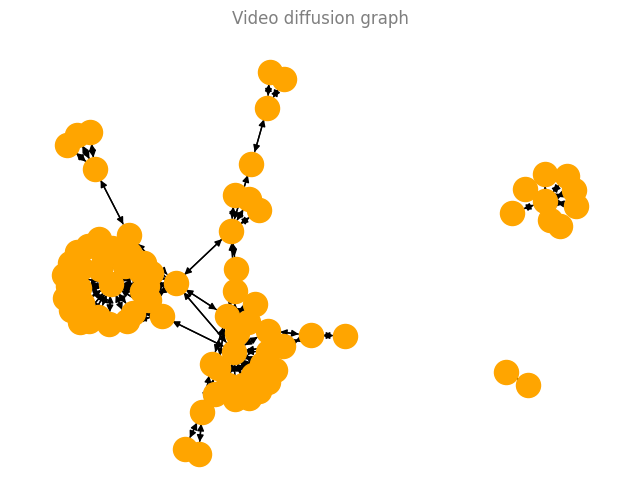

In [72]:
# Draw the combined ego graph
plt.figure(figsize=(8, 6))
# Define positions using a layout
pos = nx.spring_layout(combined_ego_graph)

# Draw nodes
nx.draw_networkx_nodes(combined_ego_graph, pos, node_color='orange')

# Draw edges
nx.draw_networkx_edges(combined_ego_graph, pos)

# Draw node labels with transparency
labels = {node: node for node in combined_ego_graph.nodes()}
alpha_value = 0.0  # Set transparency for labels
nx.draw_networkx_labels(combined_ego_graph, pos, labels, font_size=12, font_color='black', alpha=alpha_value)

# Optionally add a title with transparency
plt.title("Video diffusion graph", alpha=0.5)  # Set transparency for title text

plt.axis('off')  # Hide axes
plt.show()

In [73]:
# Assign colors: highlighted nodes in red, others in blue
highlight_color = "orange"
for node in combined_ego_graph.nodes():
    if node in all_nodes:
        combined_ego_graph.nodes[node]['color'] = highlight_color
        
nt = Network(notebook=True, font_color='#10000000')
nt.from_nx(combined_ego_graph)
nt.show("nx.html")

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


Even with a radius set to 1, which essentially creates a graph with a depth of 1, nearly all the nodes are interconnected. This tool is incredibly effective for vividly visualizing the relationships between various research papers within the same field! You can play around with different parameters to create comprehensive graph!

## **2.4 Building Graph Query Engine**

The graph query mechanism is designed to efficiently process user queries by leveraging LLM to retrieve information from a graph database. Here's a detailed breakdown of the process:

- Query Parsing: Initially, when a user submits a query, the LLM parses the query to extract key elements, typically in the form of (paper_title, relationship) pairs. 

- Graph Database Querying: Once the necessary information is extracted, the next step involves querying the graph database. The process begins with locating the node corresponding to the 'paper_title'.

- Connection Edge Retrieval: After identifying the relevant paper node, the system then searches for connection edges. It specifically looks for the edge that has the highest similarity score with the extracted 'relationship' text, using a vector search. This step ensures that the most relevant connections based on the user's query are identified.

- Result Compilation: The final step involves returning the retrieved information to the LLM. The LLM then uses this data to generate a comprehensive answer tailored to the user's query, providing insights based on the connections and data found in the graph database.

For a more visual understanding of this process, refer to the diagram below, 

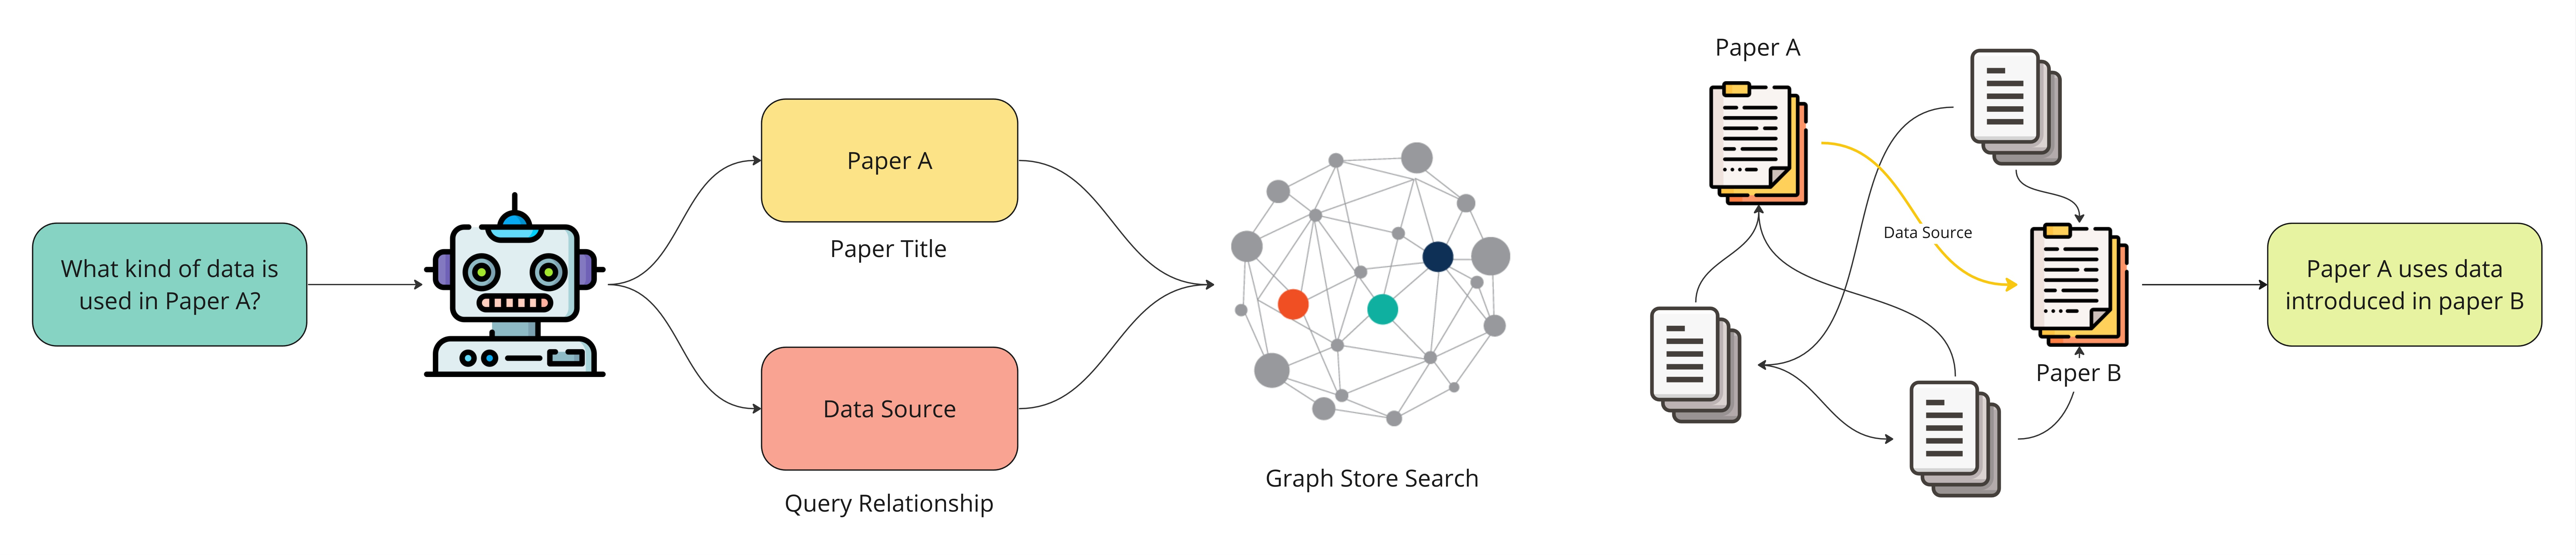

In [74]:
Image("/kaggle/input/gemmarag-figures/Graph-Mechanism.jpg")

### **2.4.1 Prepare data**

In [75]:
len(relationships_dict.keys())

135

In [76]:
relationships_prompt = {
    "Supporting Evidence": "The paper \"{source}\" provides supporting evidence for the paper \"{target}\". \nExplanation: {explanation}", 
    "Is Evidence For": "The paper \"{source}\" is supported by the paper \"{target}\". \nExplanation: {explanation}",
    "Methodological Basis": "The paper \"{source}\" is a methodological basis for the paper \"{target}\". \nExplanation: {explanation}",
    "Is Methodological Basis For": "The paper \"{source}\" is based on the methodology of the paper \"{target}\". \nExplanation: {explanation}",
    "Theoretical Foundation": "The paper \"{source}\" is a theoretical foundation for the paper \"{target}\". \nExplanation: {explanation}",
    "Is Theoretical Foundation For": "The paper \"{source}\" is based on the theoretical foundation of the paper \"{target}\". \nExplanation: {explanation}", 
    "Data Source": "The paper \"{source}\" uses the data from the paper \"{target}\". \nExplanation: {explanation}",
    "Is Data Source For": "The paper \"{source}\" provides data for the paper \"{target}\". \nExplanation: {explanation}",
    "Extension or Continuation": "The paper \"{source}\" is an extension or continuation of the paper \"{target}\". \nExplanation: {explanation}", 
    "Is Extension or Continuation Of": "The paper \"{source}\" is extended or continued by the paper \"{target}\". \nExplanation: {explanation}",
    "Unk": "The relationship bewteen the 2 papers \"{source}\", \"{target}\" is unkown {explanation}"
}

In [77]:
for key, val in relationships_dict.items():
    if key not in relationships_prompt.keys():
        relationships_prompt[key] = "The paper \"{source}\" provide " + val + " for paper \"{target}\". \nExplanation: {explanation}"
        relationships_prompt[val] = "The paper \"{source}\" is " + val + " of paper \"{target}\". \nExplanation: {explanation}"

In [78]:
print(relationships_prompt['Evaluation Protocol'])

The paper "{source}" provide Is Evaluation Protocol Of for paper "{target}". 
Explanation: {explanation}


In [79]:
# triplet_nodes = []

# for triplet in tqdm(triplets, total=len(triplets)):
#     text_prompt = relationships_prompt[triplet[1].category].format(source=triplet[0].title, target=triplet[2].title, explanation=triplet[1].explanation)
#     triplet_nodes.append(Document(text=text_prompt, metadata={"title": triplet[0].title, "arxiv_id": triplet[0].arxiv_id}))
    
# triplet_nodes[:3]

Now we extract the embedding of the relationships between nodes. Again, this process takes quite long so I have precomputed it. You can run the below code to extract the embedding from scratch

In [80]:
# ## Extract embedding for the truplets relationships
# Settings.llm = None
# # Create embed model
# device_type = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5", cache_folder="../models", device=device_type)

# chroma_client = chromadb.PersistentClient(path="../DB/graph")
# chroma_collection = chroma_client.get_or_create_collection("gemma_assistant_graph")

# vector_store = ChromaVectorStore(chroma_collection=chroma_collection)
# storage_context = StorageContext.from_defaults(vector_store=vector_store)

# index = VectorStoreIndex.from_documents(
#     triplet_nodes, storage_context=storage_context, embed_model=embed_model, show_progress=True
# )

Now, we load the relationship from the vector store

In [81]:
from llama_index.core import VectorStoreIndex, Settings
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
import chromadb
from llama_index.vector_stores.chroma import ChromaVectorStore
from llama_index.core import StorageContext
import torch


Settings.llm = None # Set this to none to make the index only do retrieval
device_type = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5", cache_folder="../models", device=device_type) # must be the same as the previous stage

chroma_client = chromadb.PersistentClient(path="./gemma-assistant-db/graph")
chroma_collection = chroma_client.get_or_create_collection("gemma_assistant_graph")
vector_store = ChromaVectorStore(chroma_collection=chroma_collection)
# load the vectorstore
storage_context = StorageContext.from_defaults(vector_store=vector_store)
rel_index = VectorStoreIndex.from_vector_store(vector_store, storage_context=storage_context, embed_model=embed_model)

LLM is explicitly disabled. Using MockLLM.


In [82]:
from llama_index.core.vector_stores.types import MetadataFilters, ExactMatchFilter


filters = MetadataFilters(filters=[
    ExactMatchFilter(
        key="title", 
        value="active learning with statistical models"
    )
])

In [83]:
graph_rel_query_engine = rel_index.as_retriever(
    similarity_top_k=10,
    filters=filters
)

In [84]:
retrieved_res = graph_rel_query_engine.retrieve("is based on the methodology of the paper")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [85]:
retrieved_res

[NodeWithScore(node=TextNode(id_='7a3970d0-9357-413c-8d21-3bf250dc4718', embedding=None, metadata={'title': 'active learning with statistical models', 'arxiv_id': 'cs/9603104'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='7211851d-f489-440e-b679-4911344123d1', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'title': 'active learning with statistical models', 'arxiv_id': 'cs/9603104'}, hash='9149b3df731eac7265caae32f013a8a5b025af15b26ff6d1c28df5de7c71ead2'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='e3db80b2-937b-45a2-9623-762f58492bd9', node_type=<ObjectType.TEXT: '1'>, metadata={'title': 'REWARD-FREE CURRICULA FOR TRAINING ROBUST WORLD MODELS', 'arxiv_id': '2306.09205'}, hash='854b7a0b5649fef888bfda873e0c560208c755dec429339477b0e980d950f54b'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='81ab7ee7-549b-43b6-aa9f-ba226df4fc04', node_type=<ObjectType.TEXT: '1'>, metadata

### **2.4.2 Building the search logic**

In [86]:
import json
import os
from typing import Any, Dict, List, Optional
from dataclasses import dataclass, field
from dataclasses_json import DataClassJsonMixin
from collections import defaultdict

import fsspec
from llama_index.core.graph_stores.types import (
    DEFAULT_PERSIST_DIR,
    DEFAULT_PERSIST_FNAME,
    GraphStore,
)
import ast
import fsspec
import logging
logger = logging.getLogger(__name__)


DEFAULT_PERSIST_DIR = "../DB/citation_graph"
DEFAULT_PERSIST_FNAME = "graph_store.json"


class CitationGraphStoreData(DataClassJsonMixin):

    """Simple Graph Store Data container.

    Args:
        graph_dict (Optional[dict]): dict mapping subject to
    """

    graph_dict: Dict[str, List[List[str]]] = defaultdict(list)
    graph_index: VectorStoreIndex = rel_index


    def find_nodes_by_keyword(self, keyword):
        """
        Find all nodes that contain the given keyword in their name.
        """
        keyword = keyword.lower()  # Convert keyword to lowercase for case-insensitive matching
        return [node for node in self.graph_dict.keys() if keyword in node.title.lower()]


    def get_rel_map(
        self, subjs: Optional[List[str]] = None, depth: int = 2, limit: int = 30
    ) -> Dict[str, List[List[str]]]:
        """Get subjects' rel map in max depth."""
        if subjs is None:
            subjs = list(self.graph_dict.keys())
        rel_map = {}
        for subj in subjs:
            rel_map[subj] = self._get_rel_map(subj.title, depth=depth, limit=limit)
        # TBD, truncate the rel_map in a spread way, now just truncate based
        # on iteration order
        rel_count = 0
        return_map = {}
        for subj in rel_map:
            if rel_count + len(rel_map[subj]) > limit:
                return_map[subj] = rel_map[subj][: limit - rel_count]
                break
            else:
                return_map[subj] = rel_map[subj]
                rel_count += len(rel_map[subj])
        return return_map

    def _get_rel_map(
        self, keyword: str, depth: int = 2, limit: int = 30
    ) -> List[List[str]]:
        """Get one subect's rel map in max depth."""
        if depth == 0:
            return []
        rel_map = []
        rel_count = 0
        subjs = self.find_nodes_by_keyword(keyword)

        if len(subjs) > 0:
            subj = subjs[0]
            for rel, obj in self.graph_dict[subj]:
                if rel_count >= limit:
                    break
                rel_map.append([subj, rel, obj])
                rel_map += self._get_rel_map(obj, depth=depth - 1)
                rel_count += 1
        return rel_map
    
    def search_vector(self, queries):
        # Example string that represents a tuple
        final_res = []
        for query_tuple in queries:
            
            # Converting string to tuple
            # result_tuple = ast.literal_eval(query_str)
            qr_title = query_tuple[0]
            qr_rel = query_tuple[1]
            nodes = self.find_nodes_by_keyword(qr_title)
            if len(nodes) == 0:
                return None
            node = nodes[0]

            filters = MetadataFilters(filters=[
                ExactMatchFilter(
                    key="title", 
                    value=node.title
                )
            ])
            retriever = self.graph_index.as_retriever(
                similarity_top_k=3,
                filters=filters
            )
            res = retriever.retrieve(qr_rel)
            final_res += [r.text for r in res] 
        
        return final_res

In [87]:
class CitationGraphStore(GraphStore):
    """Simple Graph Store.

    In this graph store, triplets are stored within a simple, in-memory dictionary.

    Args:
        simple_graph_store_data_dict (Optional[dict]): data dict
            containing the triplets. See SimpleGraphStoreData
            for more details.
    """

    def __init__(
        self,
        data: Optional[CitationGraphStoreData] = None,
        fs: Optional[fsspec.AbstractFileSystem] = None,
        **kwargs: Any,
    ) -> None:
        """Initialize params."""
        self._data = data or CitationGraphStoreData()
        self._fs = fs or fsspec.filesystem("file")

    @classmethod
    def from_persist_dir(
        cls,
        persist_dir: str = DEFAULT_PERSIST_DIR,
        fs: Optional[fsspec.AbstractFileSystem] = None,
    ) -> "CitationGraphStore":
        """Load from persist dir."""
        persist_path = os.path.join(persist_dir, DEFAULT_PERSIST_FNAME)
        return cls.from_persist_path(persist_path, fs=fs)

    @property
    def client(self) -> None:
        """Get client.
        Not applicable for this store.
        """
        return

    def get(self, subj: str) -> List[List[str]]:
        """Get triplets."""
        return self._data.graph_dict.get(subj, [])

    def get_rel_map(
        self, subjs: Optional[List[str]] = None, depth: int = 2, limit: int = 30
    ) -> Dict[str, List[List[str]]]:
        """Get depth-aware rel map."""
        return self._data.get_rel_map(subjs=subjs, depth=depth, limit=limit)

    def upsert_triplet(self, subj: str, rel: str, obj: str) -> None:
        """Add triplet."""
        if subj not in self._data.graph_dict:
            self._data.graph_dict[subj] = []
        if (rel, obj) not in self._data.graph_dict[subj]:
            self._data.graph_dict[subj].append([rel, obj])

    def delete(self, subj: str, rel: str, obj: str) -> None:
        """Delete triplet."""
        if subj in self._data.graph_dict:
            if (rel, obj) in self._data.graph_dict[subj]:
                self._data.graph_dict[subj].remove([rel, obj])
                if len(self._data.graph_dict[subj]) == 0:
                    del self._data.graph_dict[subj]

    def persist(
        self,
        persist_path: str = os.path.join(DEFAULT_PERSIST_DIR, DEFAULT_PERSIST_FNAME),
        fs: Optional[fsspec.AbstractFileSystem] = None,
    ) -> None:
        """Persist the SimpleGraphStore to a directory."""
        fs = fs or self._fs
        dirpath = os.path.dirname(persist_path)
        if not fs.exists(dirpath):
            fs.makedirs(dirpath)

        with fs.open(persist_path, "w") as f:
            json.dump(self._data.to_dict(), f)

    def get_schema(self, refresh: bool = False) -> str:
        """Get schema."""
        return "CitationGraphStore"

    def query(self, query: str, param_map: Optional[Dict[str, Any]] = {}) -> Any:
        response = []
        
        pattern = r'\(([^)]+)\)'
        tuples = re.findall(pattern, query)
        
        pairs = [tuple(item.split(",")) for item in tuples]

        # relmap = self._data.get_rel_map(subjs=pairs, depth=param_map.get("depth") or 1, limit=param_map.get("limit") or 30)
        res = self._data.search_vector(pairs)

        response.append(res)
        return response
    
    @classmethod
    def from_persist_path(
        cls, persist_path: str, fs: Optional[fsspec.AbstractFileSystem] = None
    ) -> "CitationGraphStore":
        """Create a SimpleGraphStore from a persist directory."""
        fs = fs or fsspec.filesystem("file")
        if not fs.exists(persist_path):
            logger.warning(
                f"No existing {__name__} found at {persist_path}. "
                "Initializing a new graph_store from scratch. "
            )
            return cls()

        logger.debug(f"Loading {__name__} from {persist_path}.")
        with fs.open(persist_path, "rb") as f:
            data_dict = json.load(f)
            data = CitationGraphStoreData.from_dict(data_dict)
        return cls(data)

    @classmethod
    def from_dict(cls, save_dict: dict) -> "CitationGraphStore":
        data = CitationGraphStoreData.from_dict(save_dict)
        return cls(data)

    def to_dict(self) -> dict:
        return self._data.to_dict()

In [88]:
citation_graph_store = CitationGraphStore()
for triplet in triplets:
    citation_graph_store.upsert_triplet(triplet[0], triplet[1], triplet[2])

In [89]:
input_string = """Graph Store Query:
- (tune-a-video, methodological basis)
- (tune-a-video, data sources)"""

temp_res = citation_graph_store.query(input_string)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [90]:
temp_res

[['The paper "tune-a-video: one-shot tuning of image diffusion models for text-to-video generation" is based on the methodology of the paper "SAVE: Spectral-Shift-Aware Adaptation of Image Diffusion Models for Text-driven Video Editing". \nExplanation: The cited works on modifying T2I diffusion models to fit the video generation process provide a methodological basis for the citing paper in text-guided video editing.; The cited work, Tune-A-Video, is used as a basis for adding temporal layers to the T2I model in the citing paper to instil temporal awareness in the video generation process.; The cited work provides a computationally efficient sparse-causal attention mechanism with O((mN ) 2 ) complexity that the citing paper uses to improve the self-attention mechanism in the T2I model and enhance the temporal coherence of video generation.',
  'The paper "tune-a-video: one-shot tuning of image diffusion models for text-to-video generation" is based on the methodology of the paper "Gen-

In [91]:
from llama_index.core.query_engine import KnowledgeGraphQueryEngine
from llama_index.core import PromptTemplate
from llama_index.core.prompts.prompt_type import PromptType


QUERY_KEYWORD_EXTRACT_TEMPLATE_TMPL = (
    "A question is provided below. Given the question, extract all the (paper, relationship) pars"
    "from the text. Focus on extracting the keywords that we can use "
    "to best lookup answers to the question. Avoid stopwords.\n"
    "Example: (vq-vae, continuation), (video diffusion models, data source)"
    "---------------------\n"
    "{query_str}\n"
    "---------------------\n"
    "Provide pairs in the following comma-separated format: "
    "Example 1: (('paper name', 'relationship'), ('paper name 2', 'relationship2')) \n"
    "Example 2: (('paper name', 'relationship'))\n"
)

QUERY_KEYWORD_EXTRACT_TEMPLATE = PromptTemplate(
    QUERY_KEYWORD_EXTRACT_TEMPLATE_TMPL,
    prompt_type=PromptType.QUERY_KEYWORD_EXTRACT,
)

storage_context = StorageContext.from_defaults(graph_store=citation_graph_store)

graph_query_engine = KnowledgeGraphQueryEngine(
    storage_context=storage_context,
    graph_query_synthesis_prompt=QUERY_KEYWORD_EXTRACT_TEMPLATE, 
    llm=llm,
    verbose=True)

In [92]:
Markdown(graph_query_engine.query("what are the methodological basis and data sources used in the paper 'tune-a-video'?").response)

Graph Store Query:
- (tune-a-video, methodological basis)
- (tune-a-video, data sources)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Graph Store Response:
[['The paper "tune-a-video: one-shot tuning of image diffusion models for text-to-video generation" is based on the methodology of the paper "SAVE: Spectral-Shift-Aware Adaptation of Image Diffusion Models for Text-driven Video Editing". \nExplanation: The cited works on modifying T2I diffusion models to fit the video generation process provide a methodological basis for the citing paper in text-guided video editing.; The cited work, Tune-A-Video, is used as a basis for adding temporal layers to the T2I model in the citing paper to instil temporal awareness in the video generation process.; The cited work provides a computationally efficient sparse-causal attention mechanism with O((mN ) 2 ) complexity that the citing paper uses to improve the self-attention mechanism in the T2I model and enhance the temporal coherence of video generation.', 'The paper "tune-a-video: one-shot tuning of image diffusion models for text-to-video generation" is based on the methodolog

Based on the provided context, the paper "tune-a-video: one-shot tuning of image diffusion models for text-to-video generation" relies on several methodological approaches and utilizes various data sources.

**Methodological basis:**

- **Adapting T2I diffusion models:** The paper adapts existing methodologies for modifying T2I diffusion models to fit the video generation process.
- **One-shot tuning:** The paper proposes a one-shot tuning strategy for T2I models, allowing for fine-tuning on a video without requiring multiple training iterations.
- **Sparse causal attention:** The paper employs a computationally efficient sparse causal attention mechanism to enhance the self-attention mechanism in the T2I model and improve temporal coherence in the generated video.

**Data sources:**

- **TGVE competition:** Provides a dataset of videos used to evaluate the method.
- **Gen-L-Video:** Provides a pipeline for generating long videos from text prompts.
- **CoDeF:** Provides data for obtaining video frame segmentation.
- **Instruct-Video2Avatar:** Provides pre-trained text-to-image models and attention modules for video generation.

# **3. Basic Data Science Assistant**

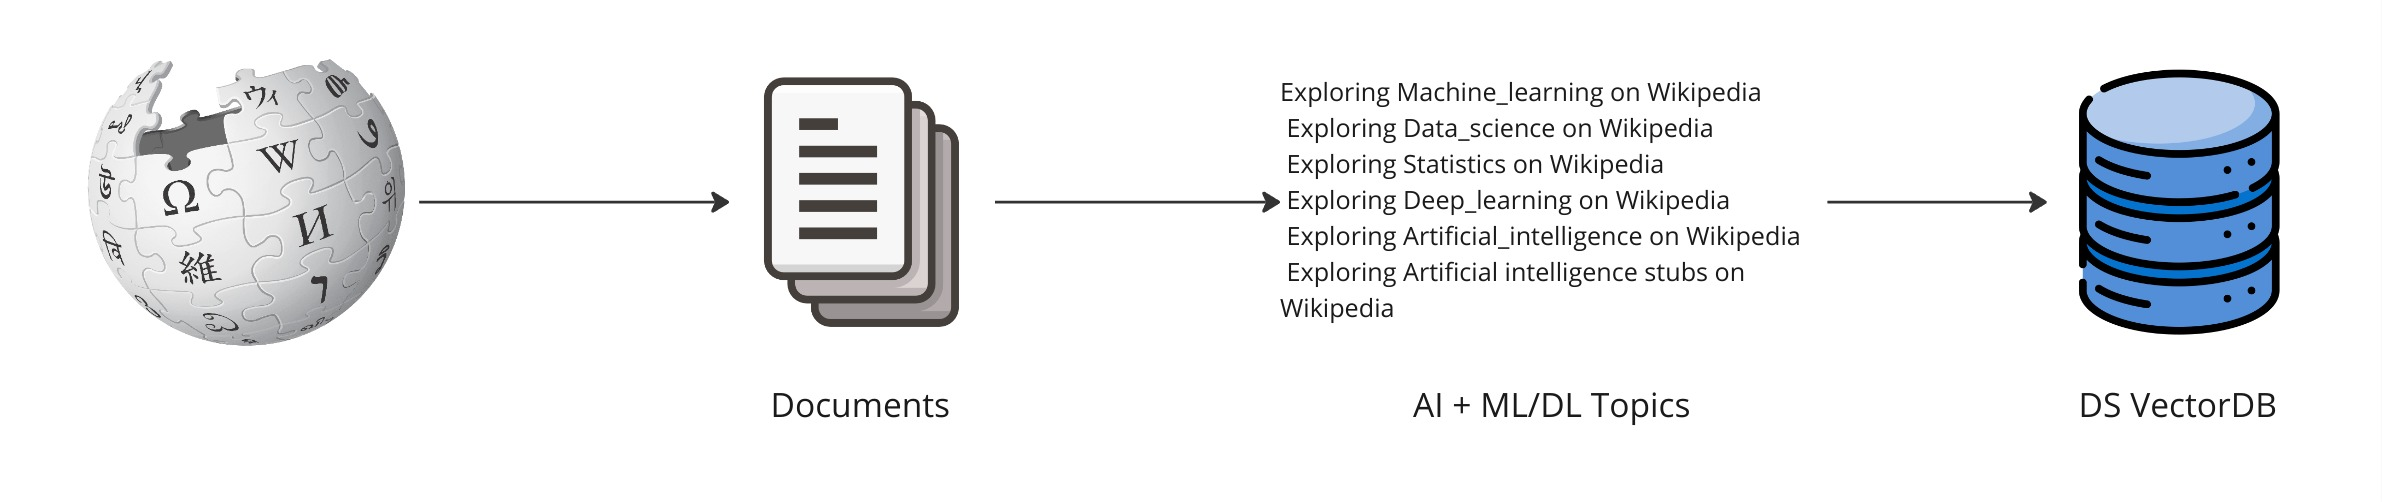

In [93]:
Image("/kaggle/input/gemmarag-figures/Data-Science-Search.jpg")

## **3.1 Download Wikipedia Data**

For data science questions, I will use the source from wikipedia

In [94]:
!pip install -q -U wikipedia-api

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [95]:
import re

# Pre-compile the regular expression pattern for better performance
BRACES_PATTERN = re.compile(r'\{.*?\}|\}')

def remove_braces_and_content(text):
    """Remove all occurrences of curly braces and their content from the given text"""
    return BRACES_PATTERN.sub('', text)

def clean_string(input_string):
    """Clean the input string."""
    
    # Remove extra spaces by splitting the string by spaces and joining back together
    cleaned_string = ' '.join(input_string.split())
    
    # Remove consecutive carriage return characters until there are no more consecutive occurrences
    cleaned_string = re.sub(r'\r+', '\r', cleaned_string)
    
    # Remove all occurrences of curly braces and their content from the cleaned string
    cleaned_string = remove_braces_and_content(cleaned_string)
    
    # Return the cleaned string
    return cleaned_string

In [96]:
def extract_wikipedia_pages(wiki_wiki, category_name):
    """Extract all references from a category on Wikipedia"""
    
    # Get the Wikipedia page corresponding to the provided category name
    category = wiki_wiki.page("Category:" + category_name)
    
    # Initialize an empty list to store page titles
    pages = []
    
    # Check if the category exists
    if category.exists():
        # Iterate through each article in the category and append its title to the list
        for article in category.categorymembers.values():
            pages.append(article.title)
    
    # Return the list of page titles
    return pages

In [97]:
import wikipediaapi
from tqdm import tqdm

def get_wikipedia_pages(categories):
    """Retrieve Wikipedia pages from a list of categories and extract their content"""
    
    # Create a Wikipedia object
    wiki_wiki = wikipediaapi.Wikipedia('Kaggle Data Science Assistant with Gemma', 'en')
    
    # Initialize lists to store explored categories and Wikipedia pages
    explored_categories = []
    wikipedia_pages = []

    # Iterate through each category
    print("- Processing Wikipedia categories:")
    for category_name in categories:
        print(f"\tExploring {category_name} on Wikipedia")
        
        # Get the Wikipedia page corresponding to the category
        category = wiki_wiki.page("Category:" + category_name)
        
        # Extract Wikipedia pages from the category and extend the list
        wikipedia_pages.extend(extract_wikipedia_pages(wiki_wiki, category_name))
        
        # Add the explored category to the list
        explored_categories.append(category_name)

    # Extract subcategories and remove duplicate categories
    categories_to_explore = [item.replace("Category:", "") for item in wikipedia_pages if "Category:" in item]
    wikipedia_pages = list(set([item for item in wikipedia_pages if "Category:" not in item]))
    
    # Explore subcategories recursively
    while categories_to_explore:
        category_name = categories_to_explore.pop()
        print(f"\tExploring {category_name} on Wikipedia")
        
        # Extract more references from the subcategory
        more_refs = extract_wikipedia_pages(wiki_wiki, category_name)

        # Iterate through the references
        for ref in more_refs:
            # Check if the reference is a category
            if "Category:" in ref:
                new_category = ref.replace("Category:", "")
                # Add the new category to the explored categories list
                if new_category not in explored_categories:
                    explored_categories.append(new_category)
            else:
                # Add the reference to the Wikipedia pages list
                if ref not in wikipedia_pages:
                    wikipedia_pages.append(ref)

    # Initialize a list to store extracted texts
    extracted_texts = []
    
    # Iterate through each Wikipedia page
    print("- Processing Wikipedia pages:")
    for page_title in tqdm(wikipedia_pages, total=len(wikipedia_pages)):
        # Get the Wikipedia page
        page = wiki_wiki.page(page_title)

        # Append the page title and summary to the extracted texts list
        if len(page.summary) > len(page.title):
            extracted_texts.append(page.title + " : " + clean_string(page.summary))
        
        # Iterate through the sections in the page
        for section in page.sections:
            # Append the page title and section text to the extracted texts list
            if len(section.text) > len(page.title):
                extracted_texts.append(page.title + " : " + clean_string(section.text))
                
    # Return the extracted texts
    return extracted_texts

In [98]:
categories = ["Machine_learning", "Data_science", "Statistics", "Deep_learning", "Artificial_intelligence"]
extracted_texts = get_wikipedia_pages(categories)
print("Found", len(extracted_texts), "Wikipedia pages")

- Processing Wikipedia categories:
	Exploring Machine_learning on Wikipedia
	Exploring Data_science on Wikipedia
	Exploring Statistics on Wikipedia
	Exploring Deep_learning on Wikipedia
	Exploring Artificial_intelligence on Wikipedia
	Exploring Artificial intelligence stubs on Wikipedia
	Exploring Works created using artificial intelligence on Wikipedia
	Exploring Virtual assistants on Wikipedia
	Exploring Turing tests on Wikipedia
	Exploring AI software on Wikipedia
	Exploring Rule engines on Wikipedia
	Exploring Artificial intelligence publications on Wikipedia
	Exploring Philosophy of artificial intelligence on Wikipedia
	Exploring Artificial intelligence people on Wikipedia
	Exploring Open-source artificial intelligence on Wikipedia
	Exploring Non-fiction books about Artificial intelligence on Wikipedia
	Exploring Neural networks on Wikipedia
	Exploring Multi-agent systems on Wikipedia
	Exploring Mind–body problem on Wikipedia
	Exploring Machine learning on Wikipedia
	Exploring Art

100%|██████████| 3411/3411 [06:30<00:00,  8.74it/s]

Found 16062 Wikipedia pages


In [99]:
# wiki_documents = [Document(text=extracted_text, doc_id=str(i)) for i, extracted_text in enumerate(extracted_texts)]

In [100]:
# chroma_client = chromadb.PersistentClient(path="../DB/wiki")
# chroma_collection = chroma_client.get_or_create_collection("gemma_assistant_wiki")


# # Create vector store
# vector_store = ChromaVectorStore(chroma_collection=chroma_collection)
# storage_context = StorageContext.from_defaults(vector_store=vector_store)

In [101]:
# index = VectorStoreIndex.from_documents(
#     wiki_documents, storage_context=storage_context, embed_model=embed_model, show_progress=True
# )

## **3.2 Loading from vector store**

In [102]:
from llama_index.core import VectorStoreIndex, Settings
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
import chromadb
from llama_index.vector_stores.chroma import ChromaVectorStore
from llama_index.core import StorageContext
import torch


Settings.llm = None # Set this to none to make the index only do retrieval
device_type = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5", cache_folder="../models", device=device_type) # must be the same as the previous stage

chroma_client = chromadb.PersistentClient(path="./gemma-assistant-db/wiki")
chroma_collection = chroma_client.get_or_create_collection("gemma_assistant_wiki")
vector_store = ChromaVectorStore(chroma_collection=chroma_collection)
# load the vectorstore
storage_context = StorageContext.from_defaults(vector_store=vector_store)
ds_index = VectorStoreIndex.from_vector_store(vector_store, storage_context=storage_context, embed_model=embed_model)


LLM is explicitly disabled. Using MockLLM.


In [103]:
data_science_query_engine = ds_index.as_query_engine(
    similarity_top_k=10,
)

In [104]:
print(data_science_query_engine.query("What is machine learning"))

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Context information is below.
---------------------
Machine learning : Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalize to unseen data, and thus perform tasks without explicit instructions. Recently, artificial neural networks have been able to surpass many previous approaches in performance.Machine learning approaches have been applied to many fields including natural language processing, computer vision, speech recognition, email filtering, agriculture, and medicine. ML is known in its application across business problems under the name predictive analytics. Although not all machine learning is statistically based, computational statistics is an important source of the field's methods. The mathematical foundations of ML are provided by mathematical optimization (mathematical programming) methods. Data mining is a related (parallel) field of study, focusing on

In [105]:
data_science_query_engine = ds_index.as_query_engine(
    similarity_top_k=10,
    llm=llm
)

In [106]:
Markdown(data_science_query_engine.query("Tell me about the outline of machine learning").response)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

The provided text outlines the following aspects of machine learning:

- **Definition:** Machine learning is a subfield of soft computing within computer science that deals with the study and construction of algorithms that can learn from and make predictions on data.


- **Historical Perspective:** The origins of machine learning can be traced back to the 1950s with the works of Arthur Samuel and Ray Solomonoff.


- **Applications:** Machine learning has diverse applications in various fields, including pattern recognition, classification, regression, and predictive modeling.


- **Theoretical Foundations:** The field draws upon concepts from statistics, probability theory, and computer science to develop algorithms and models for machine learning tasks.


- **Subfields:** Machine learning encompasses numerous subfields, such as supervised learning, unsupervised learning, reinforcement learning, and deep learning.


- **Resources:** The outline provides references to notable books, journals, and researchers in the field of machine learning.

# **4. Python Code Assistant**

## **4.1 Define a code Assistant**

In [107]:
from llama_index.core.query_engine import CustomQueryEngine
from llama_index.core import PromptTemplate

code_qa_prompt = PromptTemplate(
    "You are a code assistant powered by a large language model. "
    "Your task is to help users solve programming problems, provide code examples, "
    "explain programming concepts, and debug code. "
    "Write python code to answer the question bellow\n"
    "---------------------\n"
    "{query_str}\n"
    "---------------------\n"
    "Answer: "
)

class CodeQueryEngine(CustomQueryEngine):
    llm: Groq
    qa_prompt: PromptTemplate
    def custom_query(self , query_str: str):
        response = self.llm.complete(
            self.qa_prompt.format(query_str=query_str)
        )
#         program = extract_program(output.text)
#         executor = PythonExecutor(get_answer_from_stdout=True)
        
#         exe_result = executor.apply(program)
#         response = response.text + f"\n\n**Execution Output**:```output\n\n{exe_result[0]}\n\n```\n"
        return str(response)

In [108]:
code_query_engine = CodeQueryEngine(llm = llm, qa_prompt=code_qa_prompt)

In [109]:
try:
    Markdown(code_query_engine.query("Give me code for a basic training loop in pytorch").response)
except:
    pass

# **5. Combine all of them together**

## **5.1 Define Router Engine**

In [110]:
from llama_index.core.query_engine import RouterQueryEngine
from llama_index.core.selectors import LLMSingleSelector
from llama_index.core.tools import QueryEngineTool
# from llama_index.llms.huggingface import HuggingFaceLLM
from llama_index.llms.groq import Groq
# from unsloth import FastLanguageModel
import os

In [111]:
from typing import Any, Dict, List, Optional, Sequence, cast

from llama_index.core.base.base_selector import (
    BaseSelector,
    SelectorResult,
    SingleSelection,
)
from llama_index.core.output_parsers.base import StructuredOutput
from llama_index.core.output_parsers.selection import Answer, SelectionOutputParser
from llama_index.core.prompts.mixin import PromptDictType
from llama_index.core.prompts.prompt_type import PromptType
from llama_index.core.schema import QueryBundle
from llama_index.core.selectors.prompts import (
    DEFAULT_MULTI_SELECT_PROMPT_TMPL,
    DEFAULT_SINGLE_SELECT_PROMPT_TMPL,
    MultiSelectPrompt,
    SingleSelectPrompt,
)
from llama_index.core.service_context import ServiceContext
from llama_index.core.service_context_elements.llm_predictor import (
    LLMPredictorType,
)
from llama_index.core.settings import Settings, llm_from_settings_or_context
from llama_index.core.tools.types import ToolMetadata
from llama_index.core.types import BaseOutputParser


def _build_choices_text(choices: Sequence[ToolMetadata]) -> str:
    """Convert sequence of metadata to enumeration text."""
    texts: List[str] = []
    for ind, choice in enumerate(choices):
        text = " ".join(choice.description.splitlines())
        text = f"({ind + 1}) {text}"  # to one indexing
        texts.append(text)
    return "\n\n".join(texts)


def _structured_output_to_selector_result(output: Any) -> SelectorResult:
    """Convert structured output to selector result."""
    structured_output = cast(StructuredOutput, output)
    answers = cast(List[Answer], structured_output.parsed_output)

    # adjust for zero indexing
    selections = [
        SingleSelection(index=answer.choice - 1, reason=answer.reason)
        for answer in answers
    ]
    return SelectorResult(selections=selections)


class LLMSingleSelectorCustom(BaseSelector):
    """LLM single selector.

    LLM-based selector that chooses one out of many options.

    Args:
        LLM (LLM): An LLM.
        prompt (SingleSelectPrompt): A LLM prompt for selecting one out of many options.
    """

    def __init__(
        self,
        llm: LLMPredictorType,
        prompt: SingleSelectPrompt,
    ) -> None:
        self._llm = llm
        self._prompt = prompt

        if self._prompt.output_parser is None:
            raise ValueError("Prompt should have output parser.")

    @classmethod
    def from_defaults(
        cls,
        llm: Optional[LLMPredictorType] = None,
        service_context: Optional[ServiceContext] = None,
        prompt_template_str: Optional[str] = None,
        output_parser: Optional[BaseOutputParser] = None,
    ) -> "LLMSingleSelector":
        # optionally initialize defaults
        llm = llm or llm_from_settings_or_context(Settings, service_context)
        prompt_template_str = prompt_template_str or DEFAULT_SINGLE_SELECT_PROMPT_TMPL
        output_parser = output_parser or SelectionOutputParser()

        # construct prompt
        prompt = SingleSelectPrompt(
            template=prompt_template_str,
            output_parser=output_parser,
            prompt_type=PromptType.SINGLE_SELECT,
        )
        return cls(llm, prompt)

    def _get_prompts(self) -> Dict[str, Any]:
        """Get prompts."""
        return {"prompt": self._prompt}

    def _update_prompts(self, prompts: PromptDictType) -> None:
        """Update prompts."""
        if "prompt" in prompts:
            self._prompt = prompts["prompt"]

    def _select(
        self, choices: Sequence[ToolMetadata], query: QueryBundle
    ) -> SelectorResult:
        # prepare input
        choices_text = _build_choices_text(choices)

        # predict
        prediction = self._llm.predict(
            prompt=self._prompt,
            num_choices=len(choices),
            context_list=choices_text,
            query_str=query.query_str,
        )
        print(prediction)

        # parse output
        assert self._prompt.output_parser is not None
        parse = self._prompt.output_parser.parse(prediction)
        return _structured_output_to_selector_result(parse)

    async def _aselect(
        self, choices: Sequence[ToolMetadata], query: QueryBundle
    ) -> SelectorResult:
        # prepare input
        choices_text = _build_choices_text(choices)

        # predict
        prediction = await self._llm.apredict(
            prompt=self._prompt,
            num_choices=len(choices),
            context_list=choices_text,
            query_str=query.query_str,
        )

        # parse output
        assert self._prompt.output_parser is not None
        parse = self._prompt.output_parser.parse(prediction)
        return _structured_output_to_selector_result(parse)


In [112]:
Settings.llm = Groq(model="gemma-7b-it", api_key=groq_token)

In [113]:
paper_tool = QueryEngineTool.from_defaults(
    query_engine=paper_query_engine,
    description="Useful for search for papers",
)

graph_tool = QueryEngineTool.from_defaults(
    query_engine=graph_query_engine,
    description="Useful for answering  between papers",
)

ds_tool = QueryEngineTool.from_defaults(
    query_engine=data_science_query_engine,
    description="Useful for answering data science concepts",
)

code_tool = QueryEngineTool.from_defaults(
    query_engine=code_query_engine,
    description="Useful for answering coding questions",
)

query_engine = RouterQueryEngine(
    selector=LLMSingleSelectorCustom.from_defaults(),
    query_engine_tools=[
        paper_tool,
        ds_tool,
        graph_tool,
    ],
    verbose=True
)

In [114]:
try:
    print(query_engine.query("How to do paper research about video diffusion?"))
except:
    pass

```json
[
    {
        "choice": 1,
        "reason": "Searching for papers is a fundamental step in paper research, making it relevant to the question of how to conduct paper research on video diffusion."
    }
]
```
Selecting query engine 0: Searching for papers is a fundamental step in paper research, making it relevant to the question of how to conduct paper research on video diffusion..


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

The provided text suggests several approaches to conduct research on video diffusion models:

**Survey-based research:**

- Review existing surveys on video diffusion models to understand their fundamentals, applications, and challenges.
- Focus on specific areas of interest within video diffusion, such as video generation, editing, or understanding.


**Empirical research:**

- Analyze existing datasets for video diffusion models, such as VidProM, to identify patterns and trends.
- Experiment with different training and finetuning strategies to improve video quality and reduce replication.


**Theoretical research:**

- Develop theoretical frameworks for evaluating the quality and originality of video generation.
- Explore the use of latent representations for efficient and effective video generation.
- Research novel applications of video diffusion models in various domains.


**Technical implementation:**

- Implement your own video diffusion model or use existing libraries and fram

# **Bonus Section: Building a simple UI**

In [115]:
!pip install --upgrade gradio

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Preparing metadata (setup.py) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 53.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 6.7 MB/s eta 0:00:00
  Created wheel for ffmpy: filename=ffmpy-0.3.2-py3-none-any.whl size=5584 sha256=81115b3b22e498bfc34c1e5d6a2ebf1e5c754ec11ad630d6dc2aa168dbebc669
  Stored in directory: /root/.cache/pip/wheels/bd/65/9a/671fc6dcde07d4418df0c592f8df512b26d7a0029c2a23dd81
Successfully built ffmpy
  Attempting uninstall: websockets
    Found existing installation: websockets 12.0
    Uninstalling websockets-12.0:
      Successfully uninstalled websockets-12.0
  Attempting uninstall: tomlkit
    Found existing installation: tomlkit 0.12.4
    Uninstalling tomlkit-0.12.4:
      Successfully uninstalled tomlkit-0.12.4


In [116]:
def query_func(message, history):
    
    return query_engine.query(message).response

In [117]:
import gradio as gr

gr.ChatInterface(query_func).launch()

Running on local URL:  http://127.0.0.1:7860
Kaggle notebooks require sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Running on public URL: https://3c839bbed40ecb10b4.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
